# Irreducible Bases Generator

In [1]:
%load_ext autoreload
# provide cell timings
%load_ext autotime
# %autoreload 2
import sympy as sp
import numpy as np
from scipy.special import sph_harm as Ynm_num
# from sympy import poly, lambdify
from IPython.display import display, Math
# %config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from itertools import product
from sympy import I
# import ipywidgets as widgets
# from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import HTML, display, Math, Latex
# from matplotlib import pyplot as plt
# %matplotlib widget
# from pyperclip import copy as pypercopy
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

Reloading /Volumes/GoogleDrive/My Drive/Zia Lab/Codebase/qdef/data/CPGs.pkl ...


In [2]:
group = CPGs.get_group_by_label('O')

If one has a set of objects $\{g_i\}$, for which one knows how they transform under the operations of a group $\mathfrak{G}$, then for a given irreducible representation of the group $\Gamma^i$, one can find linear combinations of those objects that would compose a function basis for it. A function basis being a tuple of functions for which the application of any group operation results in a linear combination of the functions in the basis with the coefficients originating from the irreducible matrix representation of the operation.


In this notebook I will:

- Code a function `symmetry_adapted_basis` that takes the label for a crystallographic poing group and a maximum value of l and calculates the function bases that result from taking the spherical harmonics Ylm as generators.

- Using this function, create a dataset that computes all of this for all of the CPGs out to l=12. Load this at startup in qdef, and add it as an attribute to the class `CrystalGroup`. After this set has been generated check to see if the provided results truly transform as expected.

- Code an additional function `qet_to_irrep_basis` that takes a qet which is a linear superposition of Ylm of equal l, and which decomposes it as a sum of qets from the irreducible bases of a given group.

Note that the usefulness of these basis is that they can be used to generate multielectron bases -- expressed in terms of angular momentum states -- that transform according to the irreducible representations included in a product.

# `symmetry_adapted_basis` a lá Bradley (final version)

This calculution of symmetry adapted spherical harmonics is based on Bradley and Cracknell's "The Mathematical Theory of Symmetry in Solids".

For a given value of $l$ the proyection operator shown below is applied to all the $Y_l^m$ $(m=-l,\dots,l)$. The rows then consitute sets of linear combinations of spherical harmonics that transform according to the corresponding irreducible representation.

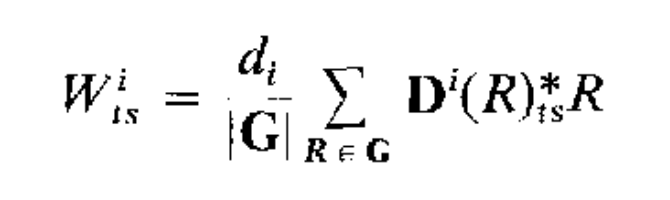

where

- $d_i$ =  dimension of the irreducible representation $\Gamma^i$,
- $|G|$ = the order of the group,
- $R$ = the operations from the group,
- $D^i(R)$ the matrix for the operation R in the irreducible representation $\Gamma^i$

The effect on an operation R can be applied to a spherical harmonic with the help of the function `RYlm` already included in `qdef.py`.

## Function foundry

A problem was found with the standard Gram-Schmidt orthonormalization algorithm from sympy 1.8. In consequence an alternative version was coded here.

In [3]:
def GramSchmidtAlt(vs, orthonormal=True):
    def projection(u,v):
        return (sp.S(u.dot(v,hermitian=True))/u.dot(u,hermitian=True))*u
    us = {}
    us[0] = vs[0]
    for k in range(1,len(vs)):
        vk = vs[k]
        projected_bit = sp.Matrix([0]*len(vs[0]))
        for j in range(k):
            projected_bit += sp.simplify(projection(us[j],vk))
        us[k] = vs[k] - projected_bit
    if orthonormal:
        es = [sp.simplify(us[k]/sp.sqrt(sp.S(us[k].dot(sp.conjugate(us[k]))))) for k in us]
        return es
    else:
        return [sp.simplify(us[k]) for k in range(len(us))]

In [78]:
def basis_check(group_label, irrep_symbol, qets, full_output = False):
    '''
    This   function   checks  if  a  list  of  qets  (which  are
    interpreted  as  superpositions  of Ylms for fixed l), are a
    basis  for  the  given representation. This is done by going
    through  all  the  operations  of  the  group,  applying the
    corresponding rotations to all of the components of the qets
    and  seeing  if  the  result  matches  what  is  obtained by
    directly    using    the    matrix   for   the   irreducible
    representation.
    '''
    group = CPGs.get_group_by_label(group_label)
    if not isinstance(irrep_symbol, sp.Symbol):
        irrep_symbol = sp.Symbol(irrep_symbol)
    if len(qets) != group.irrep_dims[irrep_symbol]:
        print("A basis needs to have as many entries as the size of the irrep!")
    the_one_ways = []
    irrep_way = []
    irrep_matrices = group.irrep_matrices[irrep_symbol]
    irrep_dim = group.irrep_dims[irrep_symbol]
    all_comparisons = {}
    all_checks = {}
    for R, DR in irrep_matrices.items():
        for idx, qet in enumerate(qets):
            direct_way = sum([v*RYlm(*k,group.euler_angles[R]) for k,v in qet.dict.items()],Qet())
            irrep_way = sum([DR[k,idx]*qets[k] for k in range(irrep_dim)],Qet())
        checks = []
        if set(irrep_way.dict.keys()) == set(direct_way.dict.keys()):
            for key in set(irrep_way.dict.keys()):
                v1 = sp.N(irrep_way.dict[key],chop=True)
                v2 = sp.N(direct_way.dict[key],chop=True)
                checks.append(sp.N(v1-v2,chop=True) == 0)
        else:
            check = (False)
        if sum(checks) == len(checks):
            check = True
        else:
            check = False
        all_comparisons[R] = (check,direct_way, irrep_way)
        all_checks[R] = check
    if sum(all_checks.values()) == len(all_checks):
        all_good = True
    else:
        all_good = False
    if full_output:
        return all_comparisons
    else:
        return all_good

In [5]:
def symmetry_adapted_basis(group_label, lmax, verbose=False):
    '''
    This function takes a  label  for a crystallographic point group and a
    maximum  value for l, and it constructs the symmetry adapted bases for
    all  of the irreducible representations of the group by taking the Ylm
    as the generating functions.

    The  result  is  a dictionary whose keys are symbols for the different
    irreducible   representations  of  the  group  and  whose  values  are
    dictionaries  whose keys are values of l and whose values are lists of
    lists  of  Qets  (in  chunks  of  length  equal  to  the  size  of the
    correspnding  irrep)  that represent the linear combinations that form
    bases  that  transform  according  to  the irreducible representation.
    These   Qets   (which  represent  linear  combinations  of  Ylms)  are
    orthonormal.

    An  empty list means that the corresponding irreducible representation
    is not contained in the subspace for the corresponding value of l.
    
    --- Example ---
    symmetry_adapted_basis('O', 3) ->
    
    {A_1: {0: [[Qet({(0, 0): 1})]], 
           1: [], 
           2: [], 
           3: []},
     A_2: {0: [],
           1: [],
           2: [],
           3: [[Qet({(3, -2): sqrt(2)/2, 
                     (3,  2): -sqrt(2)/2})]]},
     E: {0: [],
         1: [],
         2: [[Qet({(2,  0): 1}), 
              Qet({(2, -2): sqrt(2)/2, 
                   (2,  2): sqrt(2)/2})]],
         3: []},
     T_1: {0: [],
           1: [[Qet({(1, -1): sqrt(2)/2, 
                      (1, 1): -sqrt(2)/2}),
                Qet({(1,  0): I}),
                Qet({(1, -1): sqrt(2)*I/2, 
                     (1,  1): sqrt(2)*I/2})]],
           2: [],
           3: [[Qet({(3, -3): sqrt(5)/4, 
                     (3, -1): sqrt(3)/4, 
                     (3,  1): -sqrt(3)/4, 
                     (3,  3): -sqrt(5)/4}),
                Qet({(3,  0): -I}),
                Qet({(3, -3): -sqrt(5)*I/4, 
                     (3, -1): sqrt(3)*I/4, 
                     (3,  1): sqrt(3)*I/4, 
                     (3,  3): -sqrt(5)*I/4})]]},
     T_2: {0: [],
           1: [],
           2: [[Qet({(2, -2): sqrt(2)/2, 
                     (2,  2): -sqrt(2)/2}),
                Qet({(2, -1): sqrt(2)/2,
                     (2,  1): -sqrt(2)/2}),
                Qet({(2, -1): sqrt(2)*I/2, 
                     (2,  1): sqrt(2)*I/2})]],
           3: [[Qet({(3, -2): -sqrt(2)/2, 
                     (3,  2): -sqrt(2)/2}),
                Qet({(3, -3): sqrt(3)/4, 
                     (3, -1): sqrt(5)/4, 
                     (3,  1): sqrt(5)/4, 
                     (3,  3): sqrt(3)/4}),
                Qet({(3, -3): -sqrt(3)*I/4, 
                     (3, -1): sqrt(5)*I/4, 
                     (3,  1): -sqrt(5)*I/4, 
                     (3,  3): sqrt(3)*I/4})]]}}
    '''
    # The GramSchmidt routine from sympy fails in an odd case,
    # because of this I had to replace it with a custom version.
    GramSchmidtFun = GramSchmidtAlt
    # GramSchmidtFun = sp.GramSchmidt
    group = CPGs.get_group_by_label(group_label)
    group_irreps = group.irrep_labels
    symmetry_basis = {}
    for group_irrep in group_irreps:
        if verbose:
            print(str(group_irrep))
        irrep_dim = group.irrep_dims[group_irrep]
        symmetry_basis[group_irrep] = {}
        irrep_matrices = group.irrep_matrices[group_irrep]
        for l in range(lmax+1):
            full_basis = [(l,m) for m in range(-l,l+1)]
            all_phis = {}
            for m in range(-l,l+1):
                phis = {}
                # for a fixed row t,
                for t in range(irrep_dim):
                    # collect of of the sums by adding over columns
                    phi = Qet({})
                    for s in range(irrep_dim):
                        for R, DR in irrep_matrices.items():
                            dr = sp.conjugate(DR[t,s])
                            op_params = group.euler_angles[R]
                            if dr != 0:
                                phi = phi + dr*RYlm(l,m,op_params)
                        phis[(t,s)] = (sp.S(irrep_dim)/group.order)*phi
                all_phis[m] = phis
            # Take the qets and find the coefficients in the basis full_basis
            # this is necessary to evaluate linear independence, and useful
            # for applying the Gram-Schmidt orthonormalization process.
            coord_vecs = []
            #    |     | s1
            #    | t1  | s2
            # m1 |
            #    |     | s1
            #    | t2  | s2
            for m in range(-l,l+1):
                for s in range(irrep_dim):
                    for t in range(irrep_dim):
                        coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
#             for m,t,s in product(range(-l,l+1),range(irrep_dim),range(irrep_dim)):
#                 coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
            if verbose:
                print("Constructing a big matrix with coordinates in standard basis....")
            bigmatrix = sp.Matrix(coord_vecs)
            num_lin_indep_rows = (bigmatrix.rank())
            if verbose:
                print("There are %d linearly independent entries..." % (num_lin_indep_rows))
                print("Collecting that many, and in groups of %d, from the original set..." % irrep_dim)
            total_indep_rows = 0
            good_rows = []
            assert (bigmatrix.rows % irrep_dim) == 0, "No. of indep entries should divide the dim of the irrep."
            for i in range(bigmatrix.rows // irrep_dim):
                rows = coord_vecs[i*irrep_dim:i*irrep_dim+irrep_dim]
                if sp.Matrix(rows).rank() == irrep_dim:
                    good_rows.append(rows)
                    total_indep_rows += irrep_dim
                if total_indep_rows == num_lin_indep_rows:
                    break
            if verbose:
                print("Only %d rows were necessary." % len(good_rows))
                print("Orthonormalizing ...")
            # convert the coefficient vectors back to qets
            all_normal_qets = []
            for rows in good_rows:
                # normalized = list(map(list,sp.GramSchmidt([sp.Matrix(rows).row(i) for i in range(sp.Matrix(rows).rows)],orthonormal=True)))
                normalized = list(map(list, GramSchmidtFun([sp.Matrix(row) for row in rows],orthonormal=True)))
                normal_qets = [Qet({k: v for k,v in zip(full_basis,normalized[i]) if v!=0}) for i in range(len(normalized))]
                all_normal_qets.append(normal_qets)
            if verbose:
                print("Finished!")
            symmetry_basis[group_irrep][l] = all_normal_qets
    return symmetry_basis

## Run and generate dataset (Oct 20 2021)

In [6]:
# go all the way to 12
lmax = 12
sym_bases = Parallel(n_jobs = num_cores)(delayed(symmetry_adapted_basis)(group_label, lmax) for group_label in CPGs.all_group_labels)
all_the_symmetry_bases = dict(zip(CPGs.all_group_labels,sym_bases))

In [92]:
def echo(*args):
    return args
checklist_args = Parallel(n_jobs = num_cores)(delayed(echo)(group_label, irrep_symb, basis) \
                                        for group_label in CPGs.all_group_labels\
                                        for irrep_symb in CPGs.get_group_by_label(group_label).irrep_labels \
                                        for l in range(lmax) \
                                        for (basis_idx, basis) in enumerate(all_the_symmetry_bases[group_label][irrep_symb][l])
                                        )

In [83]:
checklist = Parallel(n_jobs = num_cores)(delayed(basis_check)(group_label, irrep_symb, basis) \
                                        for group_label in CPGs.all_group_labels\
                                        for irrep_symb in CPGs.get_group_by_label(group_label).irrep_labels \
                                        for l in range(lmax) \
                                        for (basis_idx, basis) in enumerate(all_the_symmetry_bases[group_label][irrep_symb][l])
                                        )

In [84]:
!beep

In [95]:
if len(checklist) == sum(checklist):
    print("Good tidings!")
    print("Out of %d instances %d passed the test." % (len(checklist), sum(checklist)))
else:
    print("Out of %d instances %d passed the test." % (len(checklist), sum(checklist)))

Ahoy!
Out of 3732 instances 3732 passed the test.


In [98]:
# pickle.dump(all_the_symmetry_bases, open('./data/symmetry_bases.pkl','wb'))

# `qet_to_irrep_basis` 

In [298]:
qet = Qet({(2,-1):-1/sp.S(2), (2,0):1/sp.S(2), (2,1):1/sp.S(2)})
lmqet_to_irrepqet('O', qet)

(2, Qet({u_{E}: 1/2, y_{T_2}: -sqrt(2)/2}))

In [294]:
# def lmqet_to_irrepqet(group_label, qet, returnbasis=False):
#     '''
#     Given  a qet whose keys are (l,m) values, for a shared value
#     of l this function determines the representation in terms of
#     irreducible basis functions.
    
#     Note    that    the    basis   obtained   from   irreducible
#     representations   may  not  necessarily  be  orthonormal  or
#     complete.
    
#     Parameters
#     ----------
    
#     group_label : str
#                 A  label for crystallographic point group, must be
#                 one of CGPs.all_group_labels
#     qet         : Qet
#                 A  Qet  whose  keys are assumed to be tuples (l,m)
#                 and whose values are complex numbers.
#     returnbasis : bool
#                 If  True, the function also returns the list whose
#                 elements are the coefficients of the basis vectors
#                 used  in  the  decomposition.  This may be used to
#                 check if the basis is orthonormal.
    
#     Returns
#     -------

#     tuple : (l, p_qet)
    
#         l       : int
#                 The value of l for the input Qet.
#         p_qet   : Qet
#                 A  Qet  whose  keys  are  labels  to components of
#                 irreducible   reps   and   whose  values  are  the
#                 corresponding coefficients. If the component label
#                 is  accompanied  by  a  left-superindex  then that
#                 number  in  parenthesis  is  indexing which of the
#                 basis this component is referring to.

#     See Also
#     --------
#     irrepqet_to_lmqet

#     Example
#     -------
    
#     >>> qet = Qet({(2,-1):-1/2, (2,0):1/2, (2,1):1/2})
#     >>> print(lmqet_to_irrepqet('O', qet))
#         (2,
#         Qet({u_{E}  : 1/2, 
#              y_{T_2}: -sqrt(2)/2}
#            )
#         )
#     '''
#     group = CPGs.get_group_by_label(group_label)
#     irrep_basis = group.symmetry_adapted_bases
#     irrep_labels = group.irrep_labels
#     # for brevity I will only consider the case where there is a single l represented
#     # in the qet
#     ls = list(set((map(lambda x: x[0],qet.dict.keys()))))
#     assert len(ls) == 1, "qet must be a supersposition of equal values of l"
#     l = ls[0]
#     l_basis = [(l,m) for m in range(-l,l+1)]
#     # pick out all the parts for this value of l
#     this_irrep_basis = {ir: irrep_basis[ir][l] for ir in irrep_labels}
#     # kick out the ones that are empty
#     this_irrep_basis = {k:v for k,v in this_irrep_basis.items() if len(v) != 0}
#     size_of_basis = {k:len(v) for k, v in this_irrep_basis.items()}
#     # convert the qets in the bases to coordinate vectors in the standard basis
#     this_irrep_basis = {(irrep_label,basis_idx):list(map(lambda x: x.vec_in_basis(l_basis), basis)) \
#                    for irrep_label, bases in this_irrep_basis.items() \
#                    for basis_idx, basis in enumerate(bases)}
#     # flatten and grab component labels
#     nice_basis = {}
    
#     for k, basis in this_irrep_basis.items():
#         irrep_label = k[0]
#         basis_idx = k[1]
#         irrep_dim = group.irrep_dims[irrep_label]
#         num_basis_vecs =  size_of_basis[irrep_label]
#         if num_basis_vecs == 1:
#             basis_labels = [(irrep_label,i,basis_idx,(group.component_labels[irrep_label][i])) for i in range((irrep_dim))]
#         else:
#             basis_labels = [(irrep_label,i,basis_idx,sp.Symbol(("{}^{(%d)}%s") % (basis_idx+1,str(group.component_labels[irrep_label][i])))) for i in range((irrep_dim))]
#         nice_basis.update(OrderedDict(zip(basis_labels, basis)))
#     # finally, proyect the qet onto the basis
#     proyected_qet = {}
#     c_qet = qet.vec_in_basis(l_basis)
#     p_qet = {k:sp.Matrix(c_qet).dot(sp.Matrix(v)) for k,v in nice_basis.items()}
#     # clean out bits that are zero, and convert to Qet
#     p_qet = Qet({k[-1]: v for k,v in p_qet.items() if v!=0})
#     if returnbasis:
#         return l, p_qet, list(nice_basis.values())
#     else:
#         return l, p_qet

In [302]:
group_label = 'O'
lmqet = Qet({(2,-2):sp.Symbol('a'), (2,0): sp.S(1)/sp.sqrt(3), (2,2): sp.S(1)/sp.sqrt(3)})
display(lmqet.as_ket())
l, irrep_qet = lmqet_to_irrepqet(group_label,lmqet)
display(irrep_qet.as_ket())
sp.simplify(irrepqet_to_lmqet(group_label, irrep_qet, 2).as_ket())

a*|(2, -2)> + sqrt(3)*|(2, 0)>/3 + sqrt(3)*|(2, 2)>/3

(sqrt(2)*a/2 - sqrt(6)/6)*|x_{T_2}> + (sqrt(2)*a/2 + sqrt(6)/6)*|v_{E}> + sqrt(3)*|u_{E}>/3

(3*a*|(2, -2)> + sqrt(3)*|(2, 0)> + sqrt(3)*|(2, 2)>)/3

In [284]:
def irrepqet_to_lmqet(group_label, irrep_qet, l, returnbasis=False):
    '''
    This  function  take  a  label  for a crystallographic point
    group  and  a  qet  written in an irreducible representation
    basis,  understood  to  originate from the given value of l,
    and  it  returns  the  representation  in the standard (l,m)
    basis.
    
    Parameters
    ----------
    
    group_label : str
                A  label for crystallographic point group, must be
                one of CGPs.all_group_labels
    irrep_qet   : Qet
                A  Qet  whose  keys  are  assumed labels for irrep
                components    and   whose   values   are   complex
                coefficients.
    returnbasis : bool
                For debugging purposes only. If True, the function
                also  returns  the  list  whose  elements  are the
                coefficients  of  the  basis  vectors  used in the
                decomposition.
    
    Returns
    -------
    tuple : (l, p_qet)
    
        l       : int
                The value of l for the input Qet.
       lm_qet   : Qet
                A  Qet  whose  keys  are  (l,m) tuples and whose
                values are complex coefficients.
                
    See Also
    --------
    lmqet_to_irrepqet
    
    Example
    -------
    
    >>> irrep_qet = Qet({sp.Symbol('u_{E}'):1/2, sp.Symbol('y_{T_2}'):-sp.sqrt(2)/2})
    >>> print(irrepqet_to_lmqet('O', irrep_qet, 2))
        (2,
        Qet({(2,-1):-1/2,
             (2,0) :1/2,
             (2,1) :1/2})
        )
    '''
    group = CPGs.get_group_by_label(group_label)
    irrep_basis = group.symmetry_adapted_bases
    irrep_labels = group.irrep_labels
    l_basis = [(l,m) for m in range(-l,l+1)]
    # pick out all the parts for this value of l
    this_irrep_basis = {ir: irrep_basis[ir][l] for ir in irrep_labels}
    # kick out the ones that are empty
    this_irrep_basis = {k:v for k,v in this_irrep_basis.items() if len(v) != 0}
    size_of_basis = {k:len(v) for k, v in this_irrep_basis.items()}
    # convert the qets in the bases to coordinate vectors in the standard basis
    this_irrep_basis = {(irrep_label,basis_idx):list(map(lambda x: x.vec_in_basis(l_basis), basis)) \
                   for irrep_label, bases in this_irrep_basis.items() \
                   for basis_idx, basis in enumerate(bases)}
    # flatten and grab component labels
    nice_basis = {}
    
    for k, basis in this_irrep_basis.items():
        irrep_label = k[0]
        basis_idx = k[1]
        irrep_dim = group.irrep_dims[irrep_label]
        num_basis_vecs =  size_of_basis[irrep_label]
        if num_basis_vecs == 1:
            basis_labels = [((group.component_labels[irrep_label][i])) for i in range((irrep_dim))]
        else:
            basis_labels = [(sp.Symbol(("{}^{(%d)}%s") % (basis_idx+1,str(group.component_labels[irrep_label][i])))) for i in range((irrep_dim))]
        nice_basis.update(OrderedDict(zip(basis_labels, basis)))
    lm_qet = [sp.Matrix(nice_basis[k])*v for k,v in irrep_qet.dict.items()]
    lm_qet = sum(lm_qet, sp.Matrix([0]*(2*l+1)))
    lm_qet = Qet(dict(zip(l_basis,lm_qet)))
    if returnbasis:
        return l, lm_qet, list(nice_basis.values())
    else:
        return l, lm_qet


## Spaguetti

In [238]:
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
irrep_basis = group.symmetry_adapted_bases
irrep_labels = group.irrep_labels
qet = Qet({(6,0): sp.S(1)/sp.sqrt(3)})
# for brevity I will only consider the case where there is a single l represented
# in the qet
ls = list(set((map(lambda x: x[0],qet.dict.keys()))))
assert len(ls) == 1, "qet must be a supersposition of equal values of l"
l = ls[0]
l_basis = [(l,m) for m in range(-l,l+1)]
# pick out all the parts for this value of l
this_irrep_basis = {ir: irrep_basis[ir][l] for ir in irrep_labels}
# kick out the ones that are empty
this_irrep_basis = {k:v for k,v in this_irrep_basis.items() if len(v) != 0}
size_of_basis = {k:len(v) for k, v in this_irrep_basis.items()}
# convert the qets in the bases to coordinate vectors in the standard basis
this_irrep_basis = {(irrep_label,basis_idx):list(map(lambda x: x.vec_in_basis(l_basis), basis)) \
                   for irrep_label, bases in this_irrep_basis.items() \
                   for basis_idx, basis in enumerate(bases)}
nice_basis = {}
for k, basis in this_irrep_basis.items():
    irrep_label = k[0]
    basis_idx = k[1]
    irrep_dim = group.irrep_dims[irrep_label]
    num_basis_vecs =  size_of_basis[irrep_label]
    if num_basis_vecs == 1:
        basis_labels = [(irrep_label,i,basis_idx,(group.component_labels[irrep_label][i])) for i in range((irrep_dim))]
    else:
        basis_labels = [(irrep_label,i,basis_idx,sp.Symbol(("{}^{(%d)}%s") % (basis_idx+1,str(group.component_labels[irrep_label][i])))) for i in range((irrep_dim))]
    nice_basis.update(OrderedDict(zip(basis_labels, basis)))
# finally, proyect the qet onto the basis
proyected_qet = {}
c_qet = qet.vec_in_basis(l_basis)
p_qet = Qet({k:sp.Matrix(c_qet).dot(sp.Matrix(v)) for k,v in nice_basis.items()})

In [239]:
p_qet.as_ket()

-sqrt(6)*|(A_1, 0, 0, a_{A_1})>/12 + sqrt(42)*|(E, 0, 0, u_{E})>/12

In [189]:
for group_label in CPGs.all_group_labels:
    for k,vs in (CPGs.get_group_by_label(group_label).component_labels).items():
        for v in vs:
            display(v)

a_{A}

a_{A_{g}}

a_{A_{u}}

a_{A}

a_{B}

a_{A^'}

a_{A^{{''}}}

a_{A_{g}}

a_{B_{u}}

a_{A_{u}}

a_{B_{g}}

a_{A_1}

a_{B_1}

a_{B_2}

a_{B_3}

a_{A_1}

a_{B_2}

a_{B_1}

a_{A_2}

a_{A_{{1g}}}

a_{B_{{3u}}}

a_{B_{{1u}}}

a_{B_{{2u}}}

a_{A_{{1u}}}

a_{B_{{3g}}}

a_{B_{{1g}}}

a_{B_{{2g}}}

a_{A}

a_{E^1}

a_{E^2}

a_{B}

a_{A}

a_{E^1}

a_{E^2}

a_{B}

a_{\Gamma^1}

a_{\Gamma^2}

a_{\Gamma^3}

a_{\Gamma^4}

a_{\Gamma^5}

a_{\Gamma^6}

a_{\Gamma^7}

a_{\Gamma^8}

a_{A_1}

a_{A_2}

a_{B_2}

a_{B_1}

u_{E}

v_{E}

a_{A_1}

a_{A_2}

a_{B_2}

a_{B_1}

u_{E}

v_{E}

a_{A_1}

a_{B_1}

a_{A_2}

a_{B_2}

u_{E}

v_{E}

a_{A_{{1g}}}

a_{A_{{2g}}}

a_{B_{{2g}}}

a_{A_{{2u}}}

a_{B_{{2u}}}

a_{B_{{1u}}}

a_{A_{{1u}}}

a_{B_{{1g}}}

u_{E_{u}}

v_{E_{u}}

u_{E_{g}}

v_{E_{g}}

a_{A}

a_{E^1}

a_{E^2}

a_{A_{g}}

a_{A_{u}}

a_{E_{u}^1}

a_{E_{u}^2}

a_{E_{g}^2}

a_{E_{g}^1}

a_{A_1}

a_{A_2}

u_{E}

v_{E}

a_{A_1}

a_{A_2}

u_{E}

v_{E}

a_{A_{{1g}}}

a_{A_{{1u}}}

a_{A_{{2u}}}

a_{A_{{2g}}}

u_{E_{g}}

v_{E_{g}}

u_{E_{u}}

v_{E_{u}}

a_{A}

a_{B}

a_{E^{{'1}}}

a_{E^{{'2}}}

a_{E^{{''2}}}

a_{E^{{''1}}}

a_{A^'}

a_{A^{{''}}}

a_{E^{{''2}}}

a_{E^{{''1}}}

a_{E^{{'2}}}

a_{E^{{'1}}}

a_{\Gamma^1}

a_{\Gamma^2}

a_{\Gamma^3}

a_{\Gamma^4}

a_{\Gamma^5}

a_{\Gamma^6}

a_{\Gamma^7}

a_{\Gamma^8}

a_{\Gamma^9}

a_{\Gamma^{10}}

a_{\Gamma^{11}}

a_{\Gamma^{12}}

a_{A_1}

a_{B_1}

a_{B_2}

a_{A_2}

u_{E_2}

v_{E_2}

u_{E_1}

v_{E_1}

a_{A_1}

a_{B_2}

a_{B_1}

a_{A_2}

u_{E_2}

v_{E_2}

u_{E_1}

v_{E_1}

a_{A_1^'}

a_{A_2^{{''}}}

a_{A_1^{{''}}}

a_{A_2^'}

u_{E^'}

v_{E^'}

u_{E^{{''}}}

v_{E^{{''}}}

a_{A_{{1g}}}

a_{A_{{2u}}}

a_{A_{{1u}}}

a_{B_{{1g}}}

a_{B_{{2g}}}

a_{B_{{1u}}}

a_{B_{{2u}}}

a_{A_{{2g}}}

u_{E_{{2g}}}

v_{E_{{2g}}}

u_{E_{{1u}}}

v_{E_{{1u}}}

u_{E_{{1g}}}

v_{E_{{1g}}}

u_{E_{{2u}}}

v_{E_{{2u}}}

a_{A}

a_{E^1}

a_{E^2}

x_{T}

y_{T}

z_{T}

a_{A_{g}}

a_{A_{u}}

a_{E_{u}^1}

a_{E_{u}^2}

a_{E_{g}^2}

a_{E_{g}^1}

x_{T_{g}}

y_{T_{g}}

z_{T_{g}}

x_{T_{u}}

y_{T_{u}}

z_{T_{u}}

a_{A_1}

a_{A_2}

u_{E}

v_{E}

x_{T_1}

y_{T_1}

z_{T_1}

x_{T_2}

y_{T_2}

z_{T_2}

a_{A_1}

a_{A_2}

u_{E}

v_{E}

x_{T_2}

y_{T_2}

z_{T_2}

x_{T_1}

y_{T_1}

z_{T_1}

a_{A_{{1g}}}

a_{A_{{2u}}}

a_{A_{{1u}}}

a_{A_{{2g}}}

u_{E_{u}}

v_{E_{u}}

u_{E_{g}}

v_{E_{g}}

x_{T_{{1g}}}

y_{T_{{1g}}}

z_{T_{{1g}}}

x_{T_{{2g}}}

y_{T_{{2g}}}

z_{T_{{2g}}}

x_{T_{{1u}}}

y_{T_{{1u}}}

z_{T_{{1u}}}

x_{T_{{2u}}}

y_{T_{{2u}}}

z_{T_{{2u}}}

# `irrep_basis_from_Ylm` a lá Bradley (version 0) : spaguetti code

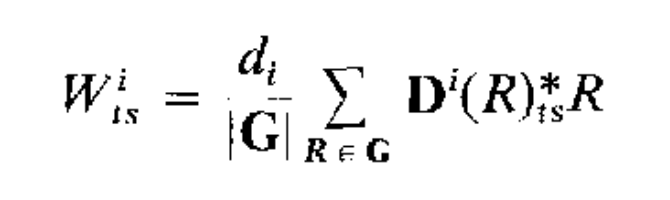

I think that the case is that out of each generating function, one can generate d_i sets of basis functions.

In [2]:
# def irrep_basis_from_Ylm_2(group_label, l):
#     '''
#     This    function   takes   a   label   group_label   for   a
#     crystallographic  point group and a value of l and returns a
#     dictionary   indexed   by  the  labels  of  the  irreducible
#     representations   of   the   group,  and  whose  values  are
#     dictionaries indexed by an integer k where k is the index of
#     the projection operator that produced the basis function.
    
#     The   returned   Qets   are  normalized  but  might  not  be
#     orthogonal.
    
#     The  keys  for  the irreducible representations are those in
#     group.irrep_labels.
    
#     --- Example ---

#     surface_harmonics('O',  6)  returns  a  dictionary with four
#     keys (A_1, A_2, E, T_1, T_2):
    
#                 {
#                 A_1: {0: Qet({(4, 4): sqrt(30)/12, 
#                               (4, -4): sqrt(30)/12, 
#                               (4, 0): sqrt(21)/6})
#                       },
#                 A_2: {},
#                 E  : {0: Qet({(4, 4): sqrt(42)/12, 
#                               (4, -4): sqrt(42)/12, 
#                               (4, 0): -sqrt(15)/6}),
#                     1: Qet({(4, 2): sqrt(2)/2, 
#                             (4, -2): sqrt(2)/2})
#                       },
#                 T_1: {0: Qet({(4, 3): 1/4, 
#                               (4, -3): 1/4, 
#                               (4, -1): -sqrt(7)/4, 
#                               (4, 1): -sqrt(7)/4}),
#                       1: Qet({(4, 4): sqrt(2)/2, 
#                               (4, -4): -sqrt(2)/2}),
#                       2: Qet({(4, 3): 1/4, 
#                               (4, -3): -1/4, 
#                               (4, -1): -sqrt(7)/4, 
#                               (4, 1): sqrt(7)/4})
#                       },
#                 T_2: {0: Qet({(4, 2): sqrt(2)/2, 
#                               (4, -2): -sqrt(2)/2}),
#                       1: Qet({(4, 3): sqrt(7)/4, 
#                               (4, -3): -sqrt(7)/4, 
#                               (4, -1): 1/4, 
#                               (4, 1): -1/4}),
#                       2: Qet({(4, 3): sqrt(7)/4, 
#                               (4, -3): sqrt(7)/4, 
#                               (4, -1): 1/4,
#                               (4, 1): 1/4}),
#                       }
#                 }
    
#     That  A_2  is  empty is compatible with the fact that A_2 is
#     not  contained  in  l=6  irreducible  representation  of the
#     rotation  group  for the cubic group O. Each set has as many
#     nonzero   Qets   as   the   dimension  of  its corresponding
#     irreducible representation.
#     '''
#     if isinstance(group_label, int):
#         group_label = CPGs.all_group_labels[group_label+1]
#     # find the group from its label
#     group = CPGs.get_group_by_label(group_label)
#     # collect the labels for its irreducible representations
#     irrep_labels = group.irrep_labels
#     basis_vecs_by_irrep = {}
#     for irrep_label in irrep_labels:
#         irrep_matrices = group.irrep_matrices[irrep_label]
#         irrep_dim = group.irrep_dims[irrep_label]
#         # this dictionary will hold all non-zero results of applying
#         # the k-th proyection operator on |l,m>
#         basis_vecs = []
#         ms = [list(range(-l,l+1))] * irrep_dim
#         for mcombo in product(*ms):
#             for k1 in range(irrep_dim):
#                 vec = Qet({})
#                 # sum over group elements R
#                 # and corresponding irreducible rep matrices
#                 for R, DR in irrep_matrices.items():
#                     # from the Euler angles one can compute
#                     # the effect that each operation has on
#                     # |l,m>
#                     op_params = group.euler_angles[R]
#                     if DR[k,k] != 0:
#                         vec = vec + DR[k,k] * RYlm_n(irrep_dim,l,mcombo,op_params)
#                 if len(vec.dict) > 0:
#                     vec = (sp.S(irrep_dim)/sp.S(group.order))*vec
#                     vec_norm = vec.norm()
#                     vec = (sp.S(1)/sp.S(vec_norm))*vec
#                     vecs.append(vec)
#             if len(vecs) == irrep_dim:
#                 basis_vecs.append(vecs)
#         if len(basis_vecs) > 0:
#             basis_vecs_by_irrep[irrep_label] = basis_vecs
#     return basis_vecs_by_irrep

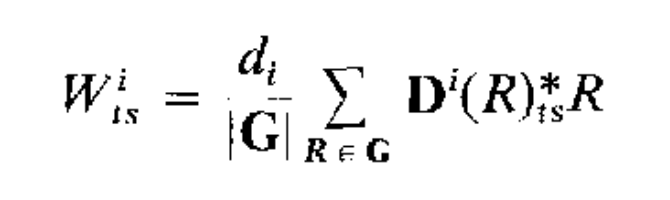

In [3]:
# # for a given group, and an irreducible representation
# group_label = 'O'
# group = CPGs.get_group_by_label(group_label)
# group_irreps = group.irrep_labels
# group_irrep = group_irreps[0]
# print(str(group_irrep))
# irrep_dim = group.irrep_dims[group_irrep]
# irrep_matrices = group.irrep_matrices[group_irrep]
# # for a given value of l
# l = 0
# full_basis = [(l,m) for m in range(-l,l+1)]
# # for each of the Ylms apply the operator above
# # by using the Euler angles for each operation
# all_phis = {}
# for m in range(-l,l+1):
#     # this will save all phis for this m
#     phis = {}
#     zmat = sp.zeros(irrep_dim, irrep_dim)
#     for s in range(irrep_dim):
#         phi = Qet({})
#         for t in range(irrep_dim):
#             for R, DR in irrep_matrices.items():
#                 dr = sp.conjugate(DR[t,s])
#                 op_params = group.euler_angles[R]
#                 if dr != 0:
#                     phi = phi + dr*RYlm(l,m,op_params)
#             phis[(t,s)] = (sp.S(irrep_dim)/group.order)*phi
#     all_phis[m] = phis

# coord_vecs = []
# for m in range(-l,l+1):
#     for s in range(irrep_dim):
#         for t in range(irrep_dim):
#             coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
# print("Constructing a big matrix with coordinates in standard basis....")
# bigmatrix = sp.Matrix(coord_vecs)
# num_lin_indep_rows = (bigmatrix.rank())
# print("There are %d linearly independent entries..." % (num_lin_indep_rows))
# print("Collecting that many, and in groups of %d, from the original set..." % irrep_dim)
# total_indep_rows = 0
# good_rows = []
# for i in range(bigmatrix.rows // irrep_dim):
#     rows = coord_vecs[i*irrep_dim:i*irrep_dim+irrep_dim]
#     if sp.Matrix(rows).rank() == irrep_dim:
#         good_rows.append(rows)
#         total_indep_rows += irrep_dim
#     if total_indep_rows == num_lin_indep_rows:
#         break
# print("Only %d rows were necessary." % len(good_rows))
# print("Orthonormalizing ...")
# all_normal_qets = []
# for i in range(len(good_rows)):
#     rows = good_rows[i]
#     normalized = list(map(list,sp.GramSchmidt([sp.Matrix(rows).row(i) for i in range(sp.Matrix(rows).rows)])))
#     normal_qets = [Qet({k: v for k,v in zip(lbasis,normalized[i]) if v!=0}) for i in range(len(normalized))]
#     all_normal_qets.append(normal_qets)
# print("Finished!")

In [4]:
# # for a given group, and an irreducible representation
# group_label = 'T_{d}'
# group = CPGs.get_group_by_label(group_label)
# group_irreps = group.irrep_labels
# symmetry_basis = {}
# lmax = 12
# verbose = True
# for group_irrep in group_irreps:
#     if group_irrep != sp.Symbol('E'):
#         continue
#     print(str(group_irrep))
#     irrep_dim = group.irrep_dims[group_irrep]
#     symmetry_basis[group_irrep] = {}
#     irrep_matrices = group.irrep_matrices[group_irrep]
#     # for a given value of l
#     for l in range(lmax+1):
#         full_basis = [(l,m) for m in range(-l,l+1)]
#         # for each of the Ylms apply the operator above
#         # by using the Euler angles for each operation
#         all_phis = {}
#         for m in range(-l,l+1):
#             # this will save all phis for this m
#             phis = {}
#             zmat = sp.zeros(irrep_dim, irrep_dim)
#             for s in range(irrep_dim):
#                 phi = Qet({})
#                 for t in range(irrep_dim):
#                     for R, DR in irrep_matrices.items():
#                         dr = sp.conjugate(DR[t,s])
#                         op_params = group.euler_angles[R]
#                         if dr != 0:
#                             phi = phi + dr*RYlm(l,m,op_params)
#                     phis[(t,s)] = (sp.S(irrep_dim)/group.order)*phi
#             all_phis[m] = phis

#         coord_vecs = []
#         for m in range(-l,l+1):
#             for s in range(irrep_dim):
#                 for t in range(irrep_dim):
#                     coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
#         if verbose:
#             print("Constructing a big matrix with coordinates in standard basis....")
#         bigmatrix = sp.Matrix(coord_vecs)
#         num_lin_indep_rows = (bigmatrix.rank())
#         if verbose:
#             print("There are %d linearly independent entries..." % (num_lin_indep_rows))
#             print("Collecting that many, and in groups of %d, from the original set..." % irrep_dim)
#         total_indep_rows = 0
#         good_rows = []
#         for i in range(bigmatrix.rows // irrep_dim):
#             rows = coord_vecs[i*irrep_dim:i*irrep_dim+irrep_dim]
#             if sp.Matrix(rows).rank() == irrep_dim:
#                 good_rows.append(rows)
#                 total_indep_rows += irrep_dim
#             if total_indep_rows == num_lin_indep_rows:
#                 break
#         if verbose:
#             print("Only %d rows were necessary." % len(good_rows))
#             print("Orthonormalizing ...")
#         all_normal_qets = []
#         for i in range(len(good_rows)):
#             rows = good_rows[i]
#             # normalized = list(map(list,sp.GramSchmidt([sp.Matrix(rows).row(i) for i in range(sp.Matrix(rows).rows)],orthonormal=True)))
# #             normalized = list(map(list,sp.GramSchmidt([sp.Matrix(row) for row in rows],orthonormal=True)))
#             normalized = list(map(list,GramSchmidtAlt([sp.Matrix(row) for row in rows],orthonormal=True)))
#             normal_qets = [Qet({k: v for k,v in zip(full_basis,normalized[i]) if v!=0}) for i in range(len(normalized))]
#             all_normal_qets.append(normal_qets)
#         if verbose:
#             print("Finished!")
#         symmetry_basis[group_irrep][l] = all_normal_qets

In [5]:
# def _QRdecomposition_optional(M, normalize=True):
#     def dot(u, v):
#         return u.dot(v, hermitian=True)

#     dps = _get_intermediate_simp(expand_mul, expand_mul)

#     A = M.as_mutable()
#     ranked = list()

#     Q = A
#     R = A.zeros(A.cols)

#     for j in range(A.cols):
#         for i in range(j):
#             if Q[:, i].is_zero_matrix:
#                 continue

#             R[i, j] = dot(Q[:, i], Q[:, j]) / dot(Q[:, i], Q[:, i])
#             R[i, j] = dps(R[i, j])
#             Q[:, j] -= Q[:, i] * R[i, j]

#         Q[:, j] = dps(Q[:, j])
#         if Q[:, j].is_zero_matrix is False:
#             ranked.append(j)
#             R[j, j] = M.one

#     Q = Q.extract(range(Q.rows), ranked)
#     R = R.extract(ranked, range(R.cols))

#     if normalize:
#         # Normalization
#         for i in range(Q.cols):
#             norm = Q[:, i].norm()
#             Q[:, i] /= norm
#             R[i, :] *= norm

In [917]:
deem = 5
vs = list(map(sp.Matrix,list(np.random.random((deem,deem)) + 1j*np.random.random((deem,deem)))))
mah = GramSchmidtAlt(vs)
em = sp.Matrix(list(map(lambda x: x.T,mah)))

In [800]:
# v1 = sp.Matrix(row[0])
# v2 = sp.Matrix(row[1])
# # v1 = sp.Matrix([3,1])
# # v2 = sp.Matrix([2,2])
# vs = [v1,v2]
# def projection(u,v):
#     return (sp.S(u.dot(v))/u.dot(u))*u
# us = {}
# us[0] = vs[0]
# for k in range(1,len(vs)):
#     vk = vs[k]
#     projected_bit = sp.Matrix([0]*len(vs[0]))
#     for j in range(k):
#         projected_bit += projection(us[j],vk)
#     us[k] = vs[k] - projected_bit
# es = {k:us[k]/sp.sqrt(sp.S(us[k].dot(us[k]))) for k in us}

In [233]:
# # testing thing sout
# group_label = 'O'
# lmax = 6
# lmin = 6
# verbose = False
# # the include GramSchmid fails in a weird case
# # had to replace the standard routine with a custom one
# def dummyGrammy(vecs, orthonormal=True):
#     return vecs
# GramSchmidtFun = GramSchmidtAlt
# # GramSchmidtFun = dummyGrammy
# # GramSchmidtFun = sp.GramSchmidt
# group = CPGs.get_group_by_label(group_label)
# group_irreps = group.irrep_labels
# symmetry_basis = {}
# big_matrices = {}
# for group_irrep in group_irreps: # [group_irreps[-1]]:
#     if verbose:
#         print(str(group_irrep))
#     irrep_dim = group.irrep_dims[group_irrep]
#     symmetry_basis[group_irrep] = {}
#     irrep_matrices = group.irrep_matrices[group_irrep]
#     for l in range(lmin,lmax+1):
#         full_basis = [(l,m) for m in range(-l,l+1)]
#         all_phis = {}
#         big_matrices[group_irrep] = {}
#         for m in range(-l,l+1):
#             phis = {}
#             # for a fixed row t,
#             for s in range(irrep_dim):
#                 # collect of of the sums by adding over columns
#                 phi = Qet({})
#                 for t in range(irrep_dim):
#                     for R, DR in irrep_matrices.items():
#                         dr = sp.conjugate(DR[t,s])
#                         op_params = group.euler_angles[R]
#                         if dr != 0:
#                             phi = phi + dr*RYlm(l,m,op_params)
#                     phis[(t,s)] = (sp.S(irrep_dim)/group.order)*phi
#             all_phis[m] = phis
#         # Take the qets and find the coefficients in the basis full_basis
#         # this is necessary to evaluate linear independence, and useful
#         # for applying the Gram-Schmidt orthonormalization process.
#         coord_vecs = []
#         #    |     | t1
#         #    | s1  | t2
#         # m1 |
#         #    |     | t1
#         #    | s2  | t2
#         #
#         #    |     | t1
#         #    | s1  | t2
#         # m2 |
#         #    |     | t1
#         #    | s2  | t2
#         #
#         #    |     | t1
#         #    | s1  | t2
#         # m3 |
#         #    |     | t1
#         #    | s2  | t2
#         # 
#         # ...
#         for m,s,t in product(range(-l,l+1),range(irrep_dim),range(irrep_dim)):
#             coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
#         for m in range(-l,l+1):
#             for s in range(irrep_dim):
#                 if len(all_phis[m][(s,s)].dict) == 0:
#                     continue
#                 for t in range(irrep_dim):
#                     coord_vecs.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
#         if verbose:
#             print("Constructing a big matrix with coordinates in standard basis....")
#         bigmatrix = sp.Matrix(coord_vecs)
#         big_matrices[group_irrep][l] = bigmatrix
#         num_lin_indep_rows = (bigmatrix.rank())
#         if verbose:
#             print("There are %d linearly independent entries..." % (num_lin_indep_rows))
#             print("Collecting that many, and in groups of %d, from the original set..." % irrep_dim)
#         total_indep_rows = 0
#         good_rows = []
#         assert (bigmatrix.rows % irrep_dim) == 0, "No. of indep entries should divide the dim of the irrep."
#         for i in range(bigmatrix.rows // irrep_dim):
#             rows = coord_vecs[i*irrep_dim:i*irrep_dim+irrep_dim]
#             if sp.Matrix(rows).rank() == irrep_dim:
#                 good_rows.append(rows)
#                 total_indep_rows += irrep_dim
#             if total_indep_rows == num_lin_indep_rows:
#                 break
#         else:
#             print("Looped with no results...")
#         if verbose:
#             print("Only %d rows were necessary." % len(good_rows))
#             print("Orthonormalizing ...")
#         # convert the coefficient vectors back to qets
#         all_normal_qets = []
#         for rows in good_rows:
#             # normalized = list(map(list,sp.GramSchmidt([sp.Matrix(rows).row(i) for i in range(sp.Matrix(rows).rows)],orthonormal=True)))
#             normalized = list(map(list, GramSchmidtFun([sp.Matrix(row) for row in rows],orthonormal=True)))
#             normal_qets = [Qet({k: v for k,v in zip(full_basis,normalized[i]) if v!=0}) for i in range(len(normalized))]
#             all_normal_qets.append(normal_qets)
#         if verbose:
#             print("Finished!")
#         symmetry_basis[group_irrep][l] = all_normal_qets

In [232]:
basis_check('O','T_2',symmetry_basis[sp.Symbol('T_2')][6][1])

True

In [231]:
symmetry_basis

{A_1: {6: [[Qet({(6, -4): sqrt(7)/4, (6, 0): -sqrt(2)/4, (6, 4): sqrt(7)/4})]]},
 A_2: {6: [[Qet({(6, -6): sqrt(10)/8, (6, -2): -sqrt(22)/8, (6, 2): -sqrt(22)/8, (6, 6): sqrt(10)/8})]]},
 E: {6: [[Qet({(6, -4): 1/4, (6, 0): sqrt(14)/4, (6, 4): 1/4}),
    Qet({(6, -6): sqrt(22)/8, (6, -2): sqrt(10)/8, (6, 2): sqrt(10)/8, (6, 6): sqrt(22)/8})]]},
 T_1: {6: [[Qet({(6, -5): sqrt(11)/8, (6, -3): -sqrt(15)/8, (6, -1): -sqrt(6)/8, (6, 1): -sqrt(6)/8, (6, 3): -sqrt(15)/8, (6, 5): sqrt(11)/8}),
    Qet({(6, -4): -sqrt(2)*I/2, (6, 4): sqrt(2)*I/2}),
    Qet({(6, -5): sqrt(11)*I/8, (6, -3): sqrt(15)*I/8, (6, -1): -sqrt(6)*I/8, (6, 1): sqrt(6)*I/8, (6, 3): -sqrt(15)*I/8, (6, 5): -sqrt(11)*I/8})]]},
 T_2: {6: [[Qet({(6, -6): sqrt(2)/2, (6, 6): -sqrt(2)/2}),
    Qet({(6, -5): sqrt(6)/32, (6, -3): sqrt(110)/32, (6, -1): 3*sqrt(11)/16, (6, 1): -3*sqrt(11)/16, (6, 3): -sqrt(110)/32, (6, 5): -sqrt(6)/32}),
    Qet({(6, -5): sqrt(6)*I/32, (6, -3): -sqrt(110)*I/32, (6, -1): 3*sqrt(11)*I/16, (6, 1): 3*sqrt

In [199]:
irrep_way

Qet({(6, -4): -sqrt(66)/64 + sqrt(22)/64, (6, 0): -sqrt(231)/32 + sqrt(77)/32, (6, 4): -sqrt(66)/64 + sqrt(22)/64, (6, -6): 11/64, (6, -2): sqrt(55)/64, (6, 2): sqrt(55)/64, (6, 6): 11/64})

In [200]:
direct_way

Qet({(6, -6): 11/64 - 11*sqrt(3)/64, (6, -4): -sqrt(66)/64 - sqrt(22)/64, (6, -2): -sqrt(165)/64 + sqrt(55)/64, (6, 0): -sqrt(231)/32 - sqrt(77)/32, (6, 2): -sqrt(165)/64 + sqrt(55)/64, (6, 4): -sqrt(66)/64 - sqrt(22)/64, (6, 6): 11/64 - 11*sqrt(3)/64})

In [156]:
qet.dict.items()

dict_items([((6, -4), 1/4), ((6, 0), sqrt(14)/4), ((6, 4), 1/4)])

In [150]:
basis_check('O','E',)

{(6, -4): 1/4, (6, 0): sqrt(14)/4, (6, 4): 1/4}


TypeError: 'dict' object is not callable

In [139]:
group.irrep_dims[sp.Symbol('E')]

2

[Qet({(6, -4): 1/4, (6, 0): sqrt(14)/4, (6, 4): 1/4}),
 Qet({(6, -6): sqrt(22)/8, (6, -2): sqrt(10)/8, (6, 2): sqrt(10)/8, (6, 6): sqrt(22)/8})]

In [134]:
def dotlist(l1,l2):
    return sum([v1*np.conjugate(v2) for v1,v2 in zip(l1,l2)])

In [137]:
np.sqrt(22*2)/8

0.82915619758885

In [135]:
v1 = sp.Matrix(symmetry_basis[sp.Symbol('E')][6][0][0].vec_in_basis(full_basis))
v1 = v1/v1.norm()
v1

Matrix([
[         0],
[         0],
[       1/4],
[         0],
[         0],
[         0],
[sqrt(14)/4],
[         0],
[         0],
[         0],
[       1/4],
[         0],
[         0]])

In [131]:
1/4*np.sqrt(2)

0.3535533905932738

In [100]:
one_matrix = []
m = 1
for s in range(irrep_dim):
    one_row = []
    if len(all_phis[m][(s,s)].dict) == 0:
                continue
    for t in range(irrep_dim):
        one_row.append(all_phis[m][(t,s)].vec_in_basis(full_basis))
    one_matrix.append(one_row)

In [116]:
vector_0 = symmetry_basis[sp.Symbol('E')][6][0][0].vec_in_basis(full_basis)

In [117]:
vector_1 = symmetry_basis[sp.Symbol('E')][6][0][1].vec_in_basis(full_basis)

In [120]:
symmetry_basis[sp.Symbol('E')][6]

[[Qet({(6, -4): sqrt(22)/32, (6, 0): sqrt(77)/16, (6, 4): sqrt(22)/32}),
  Qet({(6, -6): 11/32, (6, -4): sqrt(22)/32, (6, -2): sqrt(55)/32, (6, 0): sqrt(77)/16, (6, 2): sqrt(55)/32, (6, 4): sqrt(22)/32, (6, 6): 11/32})]]

In [118]:
dotlist(vector_0, vector_1)

11/32

In [104]:
pivot_entry = one_matrix[0][0]
withitself = sp.simplify(dotlist(pivot_entry,pivot_entry))
innner_produce = [[dotlist(pivot_entry,one_entry) for one_entry in one_row] for one_row in one_matrix]
innner_produce = sp.simplify(sp.Matrix(innner_produce))
plt.figure()
plt.imshow(np.abs(np.array(innner_produce)).astype(np.float64),cmap='inferno')
plt.colorbar()
plt.title(withitself)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[[0], [0], [0]], [[0], [0], [0]], [[0], [0], [0]]]

In [25]:
bigma = big_matrices[sp.Symbol('T_1')][6]
numrows = bigma.rows

In [35]:
inner_products = sp.Matrix([[bigma[i,:].dot(bigma[j,:], hermitian=True) for i in range(numrows) ] for j in range(numrows)])

In [38]:
plt.figure()
plt.imshow(np.abs(np.array(inner_products).astype(np.cdouble)),cmap='magma')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
sp.simplify(big_matrices[sp.Symbol('T_1')][6].T*big_matrices[sp.Symbol('T_1')][6])

Matrix([
[0,                      0,                      0,                       0, 0,                      0, 0,                       0, 0,                      0,                      0,                       0, 0],
[0,       -11/32 - 11*I/32, sqrt(22)*(-1 + 2*I)/16,            sqrt(165)/16, 0,    sqrt(66)*(1 + I)/32, 0,             sqrt(66)/16, 0,   sqrt(165)*(1 + I)/32,  sqrt(22)*(1 - 2*I)/16,                  -11/16, 0],
[0, sqrt(22)*(-1 + 2*I)/16,                      1,  -sqrt(30)*(1 + 2*I)/16, 0,    sqrt(3)*(1 - 2*I)/8, 0,    -sqrt(3)*(1 + 2*I)/8, 0,  sqrt(30)*(1 - 2*I)/16,                     -1,   sqrt(22)*(1 + 2*I)/16, 0],
[0,           sqrt(165)/16, -sqrt(30)*(1 + 2*I)/16,        -15/32 + 15*I/32, 0,         -3*sqrt(10)/16, 0, 3*sqrt(10)*I*(1 + I)/32, 0,                 -15/16,  sqrt(30)*(1 + 2*I)/16, -sqrt(165)*I*(1 + I)/32, 0],
[0,                      0,                      0,                       0, 0,                      0, 0,                       0, 0,         

In [25]:
symmetry_basis

{A_1: {6: [[Qet({(6, -4): sqrt(7)/4, (6, 0): -sqrt(2)/4, (6, 4): sqrt(7)/4})]]},
 A_2: {6: [[Qet({(6, -6): sqrt(10)/8, (6, -2): -sqrt(22)/8, (6, 2): -sqrt(22)/8, (6, 6): sqrt(10)/8})]]},
 E: {6: [[Qet({(6, -4): 1/4, (6, 0): sqrt(14)/4, (6, 4): 1/4}),
    Qet({(6, -6): sqrt(22)/8, (6, -2): sqrt(10)/8, (6, 2): sqrt(10)/8, (6, 6): sqrt(22)/8})]]},
 T_1: {6: [[Qet({(6, -5): sqrt(11)/8, (6, -3): -sqrt(15)/8, (6, -1): -sqrt(6)/8, (6, 1): -sqrt(6)/8, (6, 3): -sqrt(15)/8, (6, 5): sqrt(11)/8}),
    Qet({(6, -4): -sqrt(2)*I/2, (6, 4): sqrt(2)*I/2}),
    Qet({(6, -5): sqrt(11)*I/8, (6, -3): sqrt(15)*I/8, (6, -1): -sqrt(6)*I/8, (6, 1): sqrt(6)*I/8, (6, 3): -sqrt(15)*I/8, (6, 5): -sqrt(11)*I/8})]]},
 T_2: {6: [[Qet({(6, -6): sqrt(2)/2, (6, 6): -sqrt(2)/2}),
    Qet({(6, -5): sqrt(6)/32, (6, -3): sqrt(110)/32, (6, -1): 3*sqrt(11)/16, (6, 1): -3*sqrt(11)/16, (6, 3): -sqrt(110)/32, (6, 5): -sqrt(6)/32}),
    Qet({(6, -5): sqrt(6)*I/32, (6, -3): -sqrt(110)*I/32, (6, -1): 3*sqrt(11)*I/16, (6, 1): 3*sqrt

In [21]:
symmetry_basis

{T_2: {6: [[Qet({(6, -6): 1/2, (6, 6): -1/2}),
    Qet({(6, -6): 1/2, (6, -5): sqrt(3)/32, (6, -3): sqrt(55)/32, (6, -1): 3*sqrt(22)/32, (6, 1): -3*sqrt(22)/32, (6, 3): -sqrt(55)/32, (6, 5): -sqrt(3)/32, (6, 6): -1/2}),
    Qet({(6, -6): 1/2, (6, -5): sqrt(3)/32 + sqrt(3)*I/32, (6, -3): sqrt(55)/32 - sqrt(55)*I/32, (6, -1): 3*sqrt(22)/32 + 3*sqrt(22)*I/32, (6, 1): -3*sqrt(22)/32 + 3*sqrt(22)*I/32, (6, 3): -sqrt(55)/32 - sqrt(55)*I/32, (6, 5): -sqrt(3)/32 + sqrt(3)*I/32, (6, 6): -1/2})],
   [Qet({(6, -6): sqrt(3)/32, (6, -2): sqrt(165)/32, (6, 2): -sqrt(165)/32, (6, 6): -sqrt(3)/32}),
    Qet({(6, -6): sqrt(3)/32, (6, -5): 21/64, (6, -3): -sqrt(165)/64, (6, -2): sqrt(165)/32, (6, -1): sqrt(66)/64, (6, 1): -sqrt(66)/64, (6, 2): -sqrt(165)/32, (6, 3): sqrt(165)/64, (6, 5): -21/64, (6, 6): -sqrt(3)/32}),
    Qet({(6, -6): sqrt(3)/32, (6, -5): 21/64 + 21*I/64, (6, -3): -sqrt(165)/64 + sqrt(165)*I/64, (6, -2): sqrt(165)/32, (6, -1): sqrt(66)/64 + sqrt(66)*I/64, (6, 1): -sqrt(66)/64 + sqrt(66

In [946]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Num cores = %d' % num_cores)

Num cores = 8


In [985]:
sbases = Parallel(n_jobs = num_cores)(delayed(symmetry_adapted_basis)(group_label, 12) for group_label in CPGs.all_group_labels)

In [986]:
all_the_symmetry_bases = dict(zip(CPGs.all_group_labels,sbases))

In [997]:
all_the_symmetry_bases['O'][sp.Symbol('A_1')][12]

[[Qet({(12, -12): 5*sqrt(246)/192, (12, -8): sqrt(72611)/6560, (12, -4): sqrt(20102874)/13120, (12, 0): sqrt(166305594)/19680, (12, 4): sqrt(20102874)/13120, (12, 8): sqrt(72611)/6560, (12, 12): 5*sqrt(246)/192})],
 [Qet({(12, -12): sqrt(4197270)/75840, (12, -8): sqrt(395)/32, (12, -4): -3*sqrt(5358570)/25280, (12, 0): sqrt(109467930)/37920, (12, 4): -3*sqrt(5358570)/25280, (12, 8): sqrt(395)/32, (12, 12): sqrt(4197270)/75840})]]

In [1007]:
np.sqrt(2)*np.array(sp.N(sp.Matrix(list(all_the_symmetry_bases['O'][sp.Symbol('A_1')][12][0][0].dict.values()))))

array([[0.577632109708824],
       [0.0580914701349434],
       [0.483292703121249],
       [0.926708897163128],
       [0.483292703121249],
       [0.0580914701349434],
       [0.577632109708824]], dtype=object)

In [1018]:
all_the_symmetry_bases['O'][sp.Symbol('A_2')][12][0][0]

Qet({(12, -10): sqrt(1254)/96, (12, -6): -5*sqrt(14)/32, (12, -2): sqrt(51)/48, (12, 2): sqrt(51)/48, (12, 6): -5*sqrt(14)/32, (12, 10): sqrt(1254)/96})

In [1019]:
np.sqrt(1254*2)/96

0.5216660010645381

In [1013]:
lbasis = [(12,m) for m in range(-12,13)]
v0 = all_the_symmetry_bases['O'][sp.Symbol('A_1')][12][0][0].vec_in_basis(lbasis)
v1 = all_the_symmetry_bases['O'][sp.Symbol('A_1')][12][1][0].vec_in_basis(lbasis)

In [1017]:
GramSchmidtAlt([sp.Matrix(v0),sp.Matrix(v1)])

[Matrix([
 [      5*sqrt(246)/192],
 [                    0],
 [                    0],
 [                    0],
 [     sqrt(72611)/6560],
 [                    0],
 [                    0],
 [                    0],
 [ sqrt(20102874)/13120],
 [                    0],
 [                    0],
 [                    0],
 [sqrt(166305594)/19680],
 [                    0],
 [                    0],
 [                    0],
 [ sqrt(20102874)/13120],
 [                    0],
 [                    0],
 [                    0],
 [     sqrt(72611)/6560],
 [                    0],
 [                    0],
 [                    0],
 [      5*sqrt(246)/192]]),
 Matrix([
 [                 0],
 [                 0],
 [                 0],
 [                 0],
 [sqrt(1032954)/1640],
 [                 0],
 [                 0],
 [                 0],
 [   -sqrt(3731)/205],
 [                 0],
 [                 0],
 [                 0],
 [   9*sqrt(451)/820],
 [                 0],
 [    

In [1022]:
all_the_symmetry_bases['O'][sp.Symbol('E')]

{0: [],
 1: [],
 2: [[Qet({(2, 0): 1}), Qet({(2, -2): sqrt(2)/2, (2, 2): sqrt(2)/2})]],
 3: [],
 4: [[Qet({(4, -4): sqrt(42)/12, (4, 0): -sqrt(15)/6, (4, 4): sqrt(42)/12}),
   Qet({(4, -2): sqrt(2)/2, (4, 2): sqrt(2)/2})]],
 5: [[Qet({(5, -4): sqrt(2)/2, (5, 4): -sqrt(2)/2}),
   Qet({(5, -2): -sqrt(2)/2, (5, 2): sqrt(2)/2})]],
 6: [[Qet({(6, -4): 1/4, (6, 0): sqrt(14)/4, (6, 4): 1/4}),
   Qet({(6, -6): sqrt(22)/8, (6, -2): sqrt(10)/8, (6, 2): sqrt(10)/8, (6, 6): sqrt(22)/8})]],
 7: [[Qet({(7, -4): -sqrt(2)/2, (7, 4): sqrt(2)/2}),
   Qet({(7, -6): sqrt(39)/12, (7, -2): -sqrt(33)/12, (7, 2): sqrt(33)/12, (7, 6): -sqrt(39)/12})]],
 8: [[Qet({(8, -8): sqrt(762)/48, (8, -4): -sqrt(346710)/3048, (8, 0): -sqrt(272415)/1016, (8, 4): -sqrt(346710)/3048, (8, 8): sqrt(762)/48}),
   Qet({(8, -6): sqrt(1905)/508, (8, -2): sqrt(127127)/508, (8, 2): sqrt(127127)/508, (8, 6): sqrt(1905)/508})],
  [Qet({(8, -8): sqrt(5)/32, (8, -4): sqrt(91)/16, (8, 0): -sqrt(286)/32, (8, 4): sqrt(91)/16, (8, 8): sqrt(

In [1008]:
np.sqrt(2)*np.array(sp.N(sp.Matrix(list(all_the_symmetry_bases['O'][sp.Symbol('A_1')][12][1][0].dict.values()))))

array([[0.0382032338691252],
       [0.878341832659700],
       [-0.388493392862052],
       [0.390202566943050],
       [-0.388493392862052],
       [0.878341832659700],
       [0.0382032338691252]], dtype=object)

In [987]:
!beep

# `irrep_basis_from_Ylm`

In [2]:
# def irrep_basis_from_Ylm(group_label, l):
#     '''
#     This    function   takes   a   label   group_label   for   a
#     crystallographic  point group and a value of l and returns a
#     dictionary   indexed   by  the  labels  of  the  irreducible
#     representations   of   the   group,  and  whose  values  are
#     dictionaries indexed by an integer k where k is the index of
#     the projection operator that produced the basis function.
    
#     The   returned   Qets   are  normalized  but  might  not  be
#     orthogonal.
    
#     The  keys  for  the irreducible representations are those in
#     group.irrep_labels.
    
#     --- Example ---

#     surface_harmonics('O',  6)  returns  a  dictionary with four
#     keys (A_1, A_2, E, T_1, T_2):
    
#                 {
#                 A_1: {0: Qet({(4, 4): sqrt(30)/12, 
#                               (4, -4): sqrt(30)/12, 
#                               (4, 0): sqrt(21)/6})
#                       },
#                 A_2: {},
#                 E  : {0: Qet({(4, 4): sqrt(42)/12, 
#                               (4, -4): sqrt(42)/12, 
#                               (4, 0): -sqrt(15)/6}),
#                     1: Qet({(4, 2): sqrt(2)/2, 
#                             (4, -2): sqrt(2)/2})
#                       },
#                 T_1: {0: Qet({(4, 3): 1/4, 
#                               (4, -3): 1/4, 
#                               (4, -1): -sqrt(7)/4, 
#                               (4, 1): -sqrt(7)/4}),
#                       1: Qet({(4, 4): sqrt(2)/2, 
#                               (4, -4): -sqrt(2)/2}),
#                       2: Qet({(4, 3): 1/4, 
#                               (4, -3): -1/4, 
#                               (4, -1): -sqrt(7)/4, 
#                               (4, 1): sqrt(7)/4})
#                       },
#                 T_2: {0: Qet({(4, 2): sqrt(2)/2, 
#                               (4, -2): -sqrt(2)/2}),
#                       1: Qet({(4, 3): sqrt(7)/4, 
#                               (4, -3): -sqrt(7)/4, 
#                               (4, -1): 1/4, 
#                               (4, 1): -1/4}),
#                       2: Qet({(4, 3): sqrt(7)/4, 
#                               (4, -3): sqrt(7)/4, 
#                               (4, -1): 1/4,
#                               (4, 1): 1/4}),
#                       }
#                 }
    
#     That  A_2  is  empty is compatible with the fact that A_2 is
#     not  contained  in  l=6  irreducible  representation  of the
#     rotation  group  for the cubic group O. Each set has as many
#     nonzero   Qets   as   the   dimension  of  its corresponding
#     irreducible representation.
#     '''
#     if isinstance(group_label, int):
#         group_label = CPGs.all_group_labels[group_label+1]
#     # find the group from its label
#     group = CPGs.get_group_by_label(group_label)
#     # collect the labels for its irreducible representations
#     irrep_labels = group.irrep_labels
#     basis_vecs_by_irrep = {}
#     for irrep_label in irrep_labels:
#         irrep_matrices = group.irrep_matrices[irrep_label]
#         irrep_dim = group.irrep_dims[irrep_label]
#         # this dictionary will hold all non-zero results of applying
#         # the k-th proyection operator on |l,m>
#         basis_vecs = {}
#         for m in range(-l,l+1):
#             for k in range(irrep_dim):
#                 vec = Qet({})
#                 # sum over group elements R
#                 # and corresponding irreducible rep matrices
#                 for R, DR in irrep_matrices.items():
#                     # from the Euler angles one can compute
#                     # the effect that each operation has on
#                     # |l,m>
#                     op_params = group.euler_angles[R]
#                     if DR[k,k] != 0:
#                         vec = vec + DR[k,k] * RYlm(l,m,op_params)
#                 if len(vec.dict) > 0:
#                     vec = (sp.S(irrep_dim)/sp.S(group.order))*vec
#                     vec_norm = vec.norm()
#                     vec = (sp.S(1)/sp.S(vec_norm))*vec
#                     basis_vecs[k] = (vec)
#         if len(basis_vecs) > 0:
#             basis_vecs_by_irrep[irrep_label] = basis_vecs
#     return basis_vecs_by_irrep

In [5]:
def lmbasis_n(lmax,dim):
    def lmbasis_1(lmax):
        dim = sum([(2*l+1) for l in range(lmax+1)])
        unit_vecs = list(np.eye(dim).astype(int))
        m_tuples = []
        for l in range(lmax+1):
            m_tuples.extend([(l,m1) for m1 in range(-l,l+1)])
        return OrderedDict(zip(m_tuples, unit_vecs))
    def lmbasis_2(lmax):
        dim = sum([(2*l+1)**2 for l in range(lmax+1)])
        unit_vecs = list(np.eye(dim).astype(int))
        m_tuples = []
        for l in range(lmax+1):
            m_tuples.extend([(l,m1,m2) for m1,m2 in product(range(-l,l+1),range(-l,l+1))])
        return OrderedDict(zip(m_tuples, unit_vecs))
    def lmbasis_3(lmax):
        dim = sum([(2*l+1)**3 for l in range(lmax+1)])
        unit_vecs = list(np.eye(dim).astype(int))
        m_tuples = []
        for l in range(lmax+1):
            m_tuples.extend([(l,m1,m2,m3) for m1,m2,m3 in product(range(-l,l+1),range(-l,l+1),range(-l,l+1))])
        return OrderedDict(zip(m_tuples, unit_vecs))
    return {1:lmbasis_1,2:lmbasis_2,3:lmbasis_3}[dim](lmax)

In [173]:
def irrep_basis_from_Ylm_2(group_label, l):
    '''
    This    function   takes   a   label   group_label   for   a
    crystallographic  point group and a value of l and returns a
    dictionary   indexed   by  the  labels  of  the  irreducible
    representations   of   the   group,  and  whose  values  are
    dictionaries indexed by an integer k where k is the index of
    the projection operator that produced the basis function.
    
    The   returned   Qets   are  normalized  but  might  not  be
    orthogonal.
    
    The  keys  for  the irreducible representations are those in
    group.irrep_labels.
    
    --- Example ---

    surface_harmonics('O',  6)  returns  a  dictionary with four
    keys (A_1, A_2, E, T_1, T_2):
    
                {
                A_1: {0: Qet({(4, 4): sqrt(30)/12, 
                              (4, -4): sqrt(30)/12, 
                              (4, 0): sqrt(21)/6})
                      },
                A_2: {},
                E  : {0: Qet({(4, 4): sqrt(42)/12, 
                              (4, -4): sqrt(42)/12, 
                              (4, 0): -sqrt(15)/6}),
                    1: Qet({(4, 2): sqrt(2)/2, 
                            (4, -2): sqrt(2)/2})
                      },
                T_1: {0: Qet({(4, 3): 1/4, 
                              (4, -3): 1/4, 
                              (4, -1): -sqrt(7)/4, 
                              (4, 1): -sqrt(7)/4}),
                      1: Qet({(4, 4): sqrt(2)/2, 
                              (4, -4): -sqrt(2)/2}),
                      2: Qet({(4, 3): 1/4, 
                              (4, -3): -1/4, 
                              (4, -1): -sqrt(7)/4, 
                              (4, 1): sqrt(7)/4})
                      },
                T_2: {0: Qet({(4, 2): sqrt(2)/2, 
                              (4, -2): -sqrt(2)/2}),
                      1: Qet({(4, 3): sqrt(7)/4, 
                              (4, -3): -sqrt(7)/4, 
                              (4, -1): 1/4, 
                              (4, 1): -1/4}),
                      2: Qet({(4, 3): sqrt(7)/4, 
                              (4, -3): sqrt(7)/4, 
                              (4, -1): 1/4,
                              (4, 1): 1/4}),
                      }
                }
    
    That  A_2  is  empty is compatible with the fact that A_2 is
    not  contained  in  l=6  irreducible  representation  of the
    rotation  group  for the cubic group O. Each set has as many
    nonzero   Qets   as   the   dimension  of  its corresponding
    irreducible representation.
    '''
    if isinstance(group_label, int):
        group_label = CPGs.all_group_labels[group_label+1]
    # find the group from its label
    group = CPGs.get_group_by_label(group_label)
    # collect the labels for its irreducible representations
    irrep_labels = group.irrep_labels
    basis_vecs_by_irrep = {}
    for irrep_label in irrep_labels:
        irrep_matrices = group.irrep_matrices[irrep_label]
        irrep_dim = group.irrep_dims[irrep_label]
        # this dictionary will hold all non-zero results of applying
        # the k-th proyection operator on |l,m>
        basis_vecs = []
        ms = [list(range(-l,l+1))] * irrep_dim
        for mcombo in product(*ms):
            for k1 in range(irrep_dim):
                vec = Qet({})
                # sum over group elements R
                # and corresponding irreducible rep matrices
                for R, DR in irrep_matrices.items():
                    # from the Euler angles one can compute
                    # the effect that each operation has on
                    # |l,m>
                    op_params = group.euler_angles[R]
                    if DR[k,k] != 0:
                        vec = vec + DR[k,k] * RYlm_n(irrep_dim,l,mcombo,op_params)
                if len(vec.dict) > 0:
                    vec = (sp.S(irrep_dim)/sp.S(group.order))*vec
                    vec_norm = vec.norm()
                    vec = (sp.S(1)/sp.S(vec_norm))*vec
                    vecs.append(vec)
            if len(vecs) == irrep_dim:
                basis_vecs.append(vecs)
        if len(basis_vecs) > 0:
            basis_vecs_by_irrep[irrep_label] = basis_vecs
    return basis_vecs_by_irrep

In [175]:
huh = irrep_basis_from_Ylm_2('O',4)

In [176]:
lm_basis = lmbasis(6)

In [166]:
CPGs.get_group_by_label('O').irrep_dims

{A_1: 1, A_2: 1, E: 2, T_1: 3, T_2: 3}

In [177]:
mats = [sp.Matrix([x.vec_in_basis(list(lm_basis.keys())) for x in vecs]) for vecs in huh[sp.Symbol('T_2')]]

In [178]:
huh[sp.Symbol('T_2')][0]

[Qet({(4, -2): sqrt(2)/2, (4, 2): -sqrt(2)/2}),
 Qet({(4, -3): sqrt(7)/4, (4, -1): -1/4, (4, 1): 1/4, (4, 3): -sqrt(7)/4}),
 Qet({(4, -3): sqrt(7)/4, (4, 3): sqrt(7)/4, (4, -1): 1/4, (4, 1): 1/4})]

In [137]:
list(map(len,huh[sp.Symbol('T_2')]))

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

## Explore how the basis functions look like for the trivial irreducible representation.

Much better to plot in Mathematica, must create something that is easily importable there.

In [5]:
import multiprocessing
import time
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

In [6]:
lmax = 12
irreps_ls = Parallel(n_jobs = num_cores)(delayed(irrep_basis_from_Ylm)('O', l) for l in range(lmax+1))

In [7]:
stringos = []
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
irrep_labels = group.irrep_labels
ls = []
lmax = 12
for l in range(lmax+1):
    qets = irreps_ls[l]
    try:
        math_export= '},{'.join([','.join([str(k[0]),str(k[1]),str(v).replace('sqrt','Sqrt').replace('(','[').replace(')',']')]) for k,v in qets[irrep_labels[0]][0].dict.items()])
        math_export = 'l%d={{%s}};'%(l,math_export)
        stringos.append(math_export)
        ls.append(l)
    except:
        pass
coda = 'ls={%s};' % (','.join(list(map(lambda x: 'l%d' % x,ls))))
stringos.append(coda)
pypercopy('\n'.join(stringos))

In [8]:
from wolframclient.evaluation import WolframLanguageSession
import io
from wolframclient.language import wlexpr
from PIL import Image
class Mathematica():
    def __init__(self):
        self.session = WolframLanguageSession()
    def plot(self, plot_code):
        _ = self.evaluate(plot_code)
        data = self.evaluate( wlexpr('ExportByteArray[ plot, "PNG" ]'))
        return Image.open(io.BytesIO(data))
    def evaluate(self, code):
        return self.session.evaluate(code)

In [9]:
mathematica = Mathematica()

In [10]:
chunk_of_code = '\n'.join(stringos+['''
Os = Sum[
    p[[3]]*SphericalHarmonicY[p[[1]], 
    p[[2]], \[Theta], \[Phi]], {p, #}] & /@ ls;
sym = ParallelTable[
   Rasterize[
    SphericalPlot3D[
     Re[Os[[2]]], {\[Theta], 0, \[Pi]}, {\[Phi], 0, 2 \[Pi]}, 
     PlotRange -> All, PlotPoints -> 30, SphericalRegion -> True, 
     Boxed -> False, Axes -> False, 
     PlotStyle -> MaterialShading["Gold"], 
     ViewVector -> {5 Cos[t], 5 Sin[t], 10 Sin[t/2]}
                   ]
     ],
    {t, 0, 4 \[Pi], 2 \[Pi]/18}
   ];
plot = GraphicsGrid[Partition[sym, 6], ImageSize -> 800];
'''])

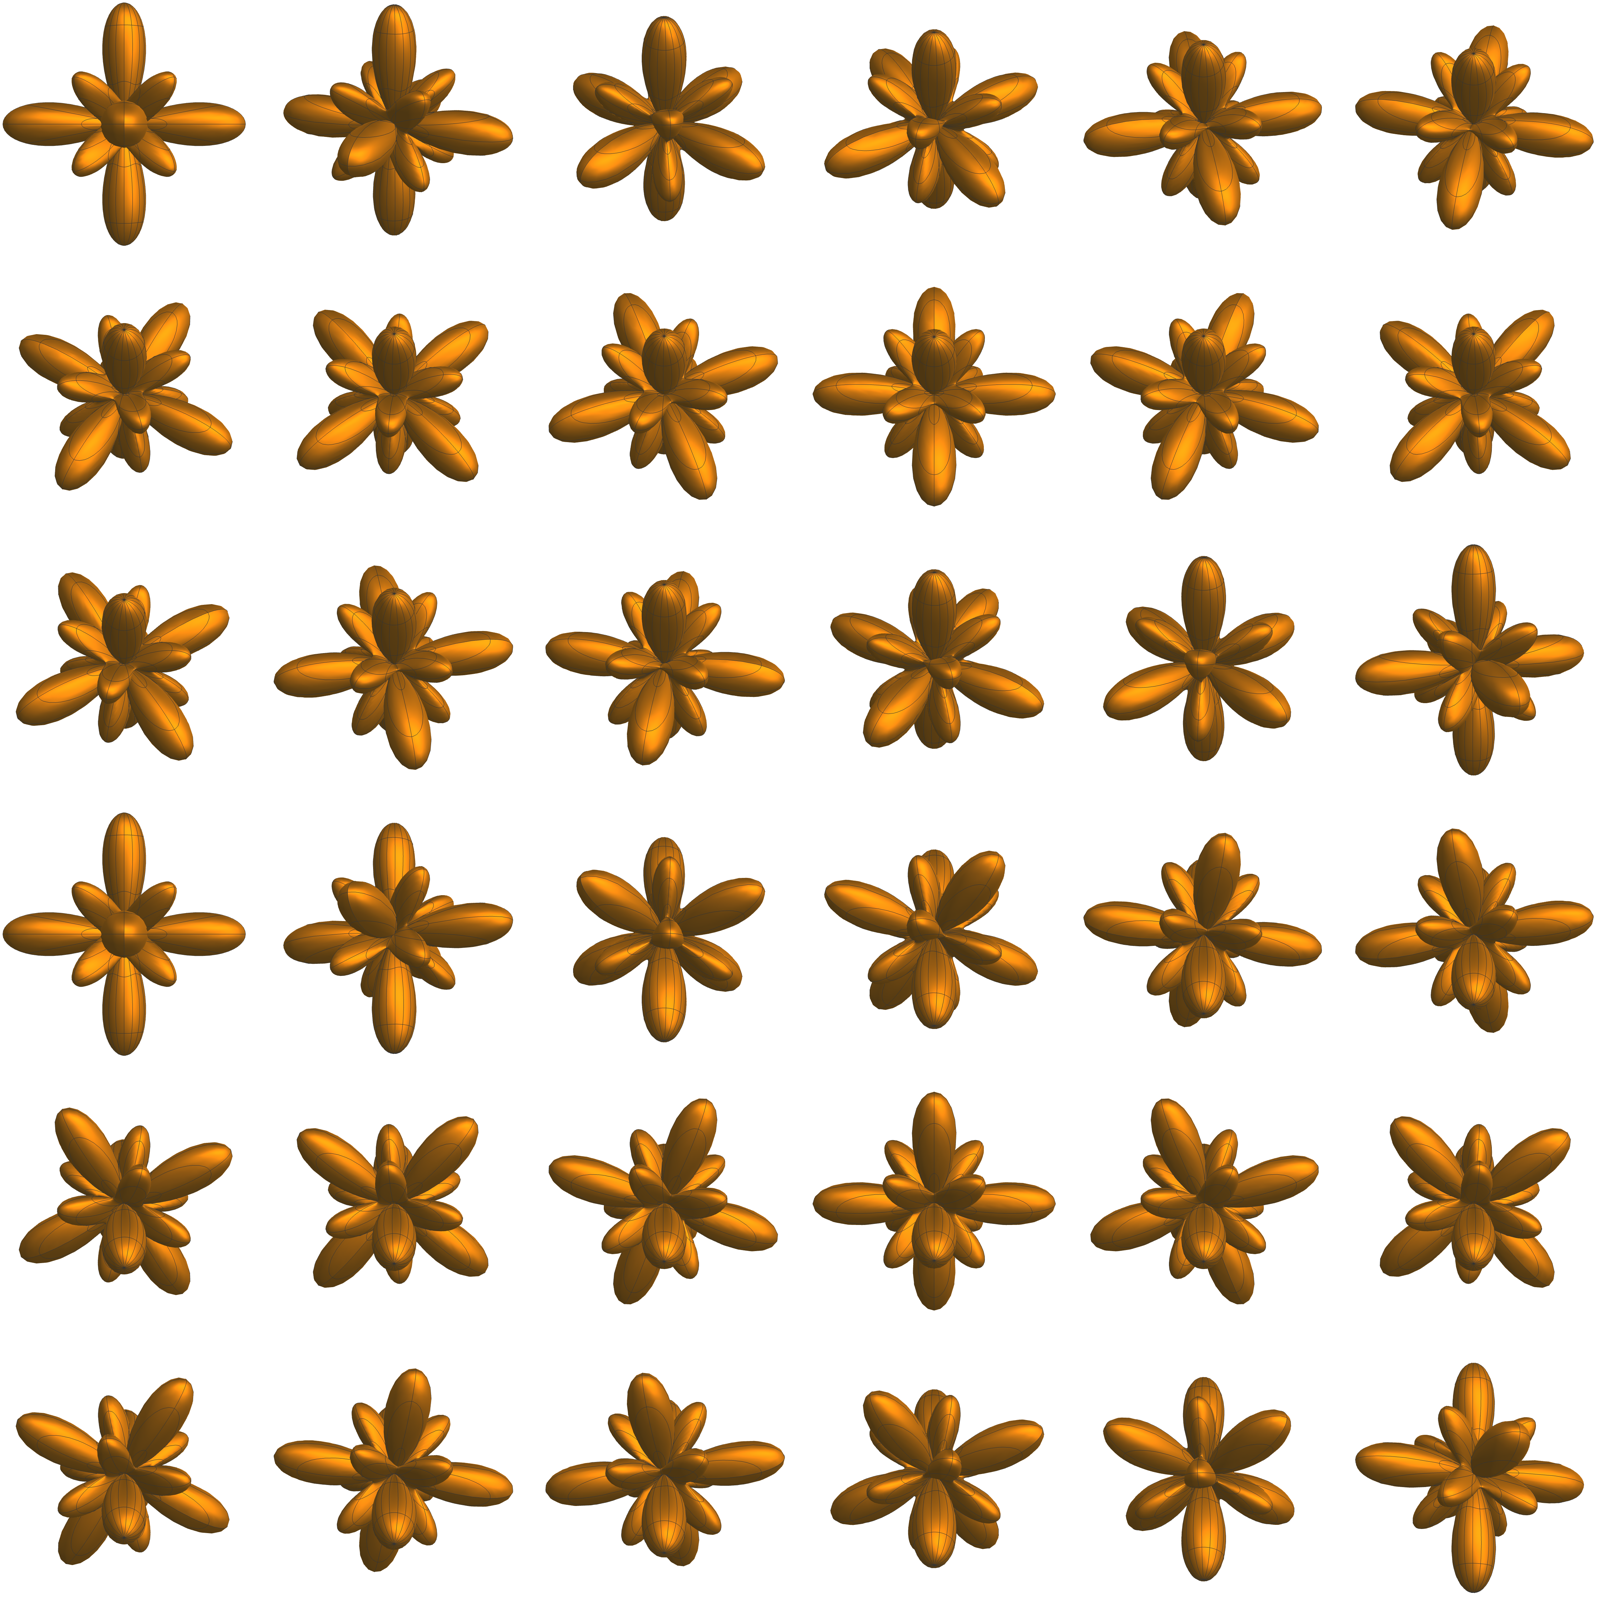

In [11]:
mathematica.plot(chunk_of_code)

In [10]:
!beep

# `sym_basis_decomposition`

In [14]:
import pickle

In [83]:
lmax = 12
sym_bases = {}
lm_basis = lmbasis(lmax)
for group_label in CPGs.all_group_labels:
    print(group_label)
    irreps_ls = Parallel(n_jobs = num_cores)(delayed(irrep_basis_from_Ylm)(group_label, l) for l in range(lmax+1))
    sym_bases[group_label] = irreps_ls
    break
# !beep

C_{1}


In [15]:
pickle.dump(sym_bases, open('./data/symmetry_bases.pkl','wb'))

In [53]:
flat_sym_bases = {}
for group_label in CPGs.all_group_labels:
    group = CPGs.get_group_by_label(group_label)
    irrep_labels = group.irrep_labels
    irreps_ls = sym_bases[group_label]
    nice_basis = {}
    for l in range(lmax+1):
        irrep_basis = irreps_ls[l]
        for irrep_label in irrep_basis.keys():
            if len(irrep_basis[irrep_label]) == 0:
                continue
            irrep_dim = group.irrep_dims[irrep_label]
            if irrep_label not in nice_basis.keys():
                nice_basis[irrep_label] = {}
            for irrep_idx in range(irrep_dim):
                nice_basis[irrep_label][(str(irrep_label),l,irrep_idx)] = irrep_basis[irrep_label][irrep_idx]
    flat_sym_bases[group_label] = nice_basis

In [54]:
pickle.dump(flat_sym_bases, open('./data/flat_symmetry_bases.pkl','wb'))

In [55]:
# # converting qets to regular dictionaries
# sym_bases_in_dicts = {}
# for group_label in sym_bases:
#     this_irreps = sym_bases[group_label]
#     sym_bases_in_dicts[group_label] = []
#     for anl in this_irreps:
#          sym_bases_in_dicts[group_label].append({k: {idx: q.dict for idx, q in v.items()} for k,v in anl.items()})

In [56]:
# pickle.dump(sym_bases_in_dicts, open('./data/sym_bases_in_dicts.pkl','wb'))

In [140]:
def lmbasis(lmax):
    '''
    Returns an OrderedDict whose keys correspond to (l,m) up till l=lmax
    and whose values are coordinate vectors corresponding to them.
    '''
    lm_basis = OrderedDict()
    basis_dim = (lmax+1)**2
    counter = 0
    for l in range(lmax+1):
        for m in range(-l,l+1):
            coord_vec = sp.Matrix([0]*basis_dim)
            coord_vec[counter] = 1
            lm_basis[(l,m)] = coord_vec
            counter += 1
    return lm_basis

In [3]:
def RYlm(l, m, op_params):
    '''
    Given  a group operation (as parametrized with the
    iterable  op_params which contains Euler angles α,
    β,  γ  and  the determinant of the operation) this
    function   returns   the  effect  that  that  this
    operation has on the sperical harmonic Y_lm.

    The  result  is  a  qet  whose  keys correspond to
    values   of   (l,m)   and  whose  values  are  the
    corresponding coefficients. Keys not present imply
    that the corresponding coefficient is zero.

    --- Example ---

    RYlm(1,0,(pi, pi/2, pi, 1) ->

    Qet({(2, -2): 1/4,
         (2, -1): 1/2,
         (2, 0): sqrt(6)/4,
         (2, 1): -1/2,
         (2, 2): 1/4})

    '''
    alpha, beta, gamma, detOp = op_params
    Rf = Qet()
    for nn in range(-l,l+1):
        wigD = Wigner_D(l, m, nn, alpha, beta, gamma)
        if wigD != 0:
            Rf = Rf + Qet({(l,nn): wigD})
    return (sp.S(detOp)**l) * Rf

def RYlm_2(l, m1, m2, op_params):
    '''
    Given  a group operation (as parametrized with the
    iterable  op_params which contains Euler angles α,
    β,  γ  and  the determinant of the operation) this
    function   returns   the  effect  that  that  this
    operation  has  on  the  product  of two spherical
    harmonics Ylm1 * Ylm2.

    The  result  is  a  qet  whose  keys correspond to
    values  of  (l,m1,m2,m3)  and whose values are the
    corresponding coefficients. Keys not present imply
    that the corresponding coefficient is zero.
    '''
    alpha, beta, gamma, detOp = op_params
    Rf = Qet()
    for nn0 in range(-l,l+1):
        wigD0 = Wigner_D(l, m1, nn0, alpha, beta, gamma)
        for nn1 in range(-l,l+1):
            wigD1 = Wigner_D(l, m2, nn1, alpha, beta, gamma)
            wigD = wigD0*wigD1
            if wigD != 0:
                Rf = Rf + Qet({(l,nn0,nn1): wigD})
    return Rf

def RYlm_3(l, m1, m2, m3, op_params):
    '''
    Given  a group operation (as parametrized with the
    iterable  op_params which contains Euler angles α,
    β,  γ  and  the determinant of the operation) this
    function   returns   the  effect  that  that  this
    operation  has  on  the product of three spherical
    harmonics Ylm1 * Ylm2 * Ylm3.

    The  result  is  a  qet  whose  keys correspond to
    values  of  (l,m1,m2,m3)  and whose values are the
    corresponding coefficients. Keys not present imply
    that the corresponding coefficient is zero.
    '''
    alpha, beta, gamma, detOp = op_params
    Rf = Qet()
    for nn0 in range(-l,l+1):
        wigD0 = Wigner_D(l, m1, nn0, alpha, beta, gamma)
        for nn1 in range(-l,l+1):
            wigD1 = Wigner_D(l, m2, nn1, alpha, beta, gamma)
            for nn2 in range(-l,l+1):
                wigD2 = Wigner_D(l, m3, nn2, alpha, beta, gamma)
                wigD = wigD0 * wigD1 * wigD2
                if wigD != 0:
                    Rf = Rf + Qet({(l,nn0,nn1,nn2): wigD})
    return (sp.S(detOp)**l) * Rf

def RYlm_n(dim,l, ms, op_params):
    return {1:RYlm, 2:RYlm_2, 3:RYlm_3}[dim](l, *ms, op_params)

In [4]:
RYlm_n(3, 2, (2,1,0), (pi, pi/2, pi, 1)).as_ket()

-sqrt(6)*|(2, -2, -2, -2)>/32 + |(2, -2, -2, 0)>/16 - sqrt(6)*|(2, -2, -2, 2)>/32 - sqrt(6)*|(2, -2, -1, -2)>/32 + |(2, -2, -1, 0)>/16 - sqrt(6)*|(2, -2, -1, 2)>/32 - sqrt(6)*|(2, -2, 1, -2)>/32 + |(2, -2, 1, 0)>/16 - sqrt(6)*|(2, -2, 1, 2)>/32 + sqrt(6)*|(2, -2, 2, -2)>/32 - |(2, -2, 2, 0)>/16 + sqrt(6)*|(2, -2, 2, 2)>/32 - sqrt(6)*|(2, -1, -2, -2)>/16 + |(2, -1, -2, 0)>/8 - sqrt(6)*|(2, -1, -2, 2)>/16 - sqrt(6)*|(2, -1, -1, -2)>/16 + |(2, -1, -1, 0)>/8 - sqrt(6)*|(2, -1, -1, 2)>/16 - sqrt(6)*|(2, -1, 1, -2)>/16 + |(2, -1, 1, 0)>/8 - sqrt(6)*|(2, -1, 1, 2)>/16 + sqrt(6)*|(2, -1, 2, -2)>/16 - |(2, -1, 2, 0)>/8 + sqrt(6)*|(2, -1, 2, 2)>/16 - 3*|(2, 0, -2, -2)>/16 + sqrt(6)*|(2, 0, -2, 0)>/16 - 3*|(2, 0, -2, 2)>/16 - 3*|(2, 0, -1, -2)>/16 + sqrt(6)*|(2, 0, -1, 0)>/16 - 3*|(2, 0, -1, 2)>/16 - 3*|(2, 0, 1, -2)>/16 + sqrt(6)*|(2, 0, 1, 0)>/16 - 3*|(2, 0, 1, 2)>/16 + 3*|(2, 0, 2, -2)>/16 - sqrt(6)*|(2, 0, 2, 0)>/16 + 3*|(2, 0, 2, 2)>/16 + sqrt(6)*|(2, 1, -2, -2)>/16 - |(2, 1, -2, 0)>/8 + sqr

In [25]:
# group_label = 'O'
# group = CPGs.get_group_by_label(group_label)
# irrep_labels = group.irrep_labels
# nice_basis = {}
# irreps_ls = sym_bases[group_label]
# for l in range(lmax+1):
#     irrep_basis = irreps_ls[l]
#     for irrep_label in irrep_basis.keys():
#         if len(irrep_basis[irrep_label]) == 0:
#             continue
#         irrep_dim = group.irrep_dims[irrep_label]
#         if irrep_label not in nice_basis.keys():
#             nice_basis[irrep_label] = {}
#         for irrep_idx in range(irrep_dim):
#             nice_basis[irrep_label][(str(irrep_label),l,irrep_idx)] = irrep_basis[irrep_label][irrep_idx]

In [29]:
# lm_basis = lmbasis(lmax)

In [66]:
# sym_basis = []
# for irrep_label, vecs in nice_basis.items():
#     sym_basis.extend([k.vec_in_basis(list(lm_basis.keys())) for k in vecs.values()])

In [67]:
def sym_basis_decomposition(group, lmax, qet):
    nice_basis = flat_sym_bases[group]
    lm_basis = lmbasis(lmax)
    new_qet = {}
    v0 = sp.Matrix(qet.vec_in_basis(list(lm_basis.keys())))
    for irrep_label, basis_vecs_for_irrep in nice_basis.items():
        new_qet[irrep_label] = {}
        for basis_vec_label, basis_vec_qet in basis_vecs_for_irrep.items():   
            v1 = sp.Matrix(basis_vec_qet.vec_in_basis(list(lm_basis.keys())))
            dotp = v0.dot(v1)
            if dotp != 0:
                new_qet[irrep_label][basis_vec_label] = sp.S(dotp)
    return new_qet

In [68]:
qet = Qet({(6, 4): sp.S(1)/4, (6, -4): sp.S(1)/4, (6, 0): sp.sqrt(14)/4}) + Qet({(1, 1): sp.sqrt(2)/2, (1, -1): sp.sqrt(2)/2})

In [81]:
group = CPGs.get_group_by_label('C_{1}')

In [82]:
group.operations_matrices

{{Ee}: Matrix([
 [1, 0, 0],
 [0, 1, 0],
 [0, 0, 1]])}

In [73]:
flat_sym_bases['C_{1}']

{A: {('A', 0, 0): Qet({(0, 0): 1}),
  ('A', 1, 0): Qet({(1, 1): 1}),
  ('A', 2, 0): Qet({(2, 2): 1}),
  ('A', 3, 0): Qet({(3, 3): 1}),
  ('A', 4, 0): Qet({(4, 4): 1}),
  ('A', 5, 0): Qet({(5, 5): 1}),
  ('A', 6, 0): Qet({(6, 6): 1}),
  ('A', 7, 0): Qet({(7, 7): 1}),
  ('A', 8, 0): Qet({(8, 8): 1}),
  ('A', 9, 0): Qet({(9, 9): 1}),
  ('A', 10, 0): Qet({(10, 10): 1}),
  ('A', 11, 0): Qet({(11, 11): 1}),
  ('A', 12, 0): Qet({(12, 12): 1})}}

In [70]:
sym_basis_decomposition('C_{1}', 12 , qet)

{A: {('A', 1, 0): sqrt(2)/2}}

In [34]:
plt.figure()
plt.imshow(np.array(sym_basis).astype(np.float64))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Recycling Bin

In [170]:
group_label = 'D_{3h}'
group = CPGs.get_group_by_label(group_label)
lmax = 15
ls = list(range(lmax+1))
def simplesurf(l):
    salcs = {}
    for m in range(-l,l+1):
        SALC = Qet()
        for group_params in group.euler_angles.values():
            alpha, beta, gamma, detRot = group_params
            SALC = SALC + RYlm(l,m,alpha,beta,gamma,detRot)
        if len(SALC.dict) > 0:
            salcs[(l,m)] = (sp.S(1)/group.order)*SALC
    return salcs
all_salcs = Parallel(n_jobs=10)(delayed(simplesurf)(i) for i in range(lmax+1))
SALCs = {}
for salcs in all_salcs:
    SALCs.update(salcs)

In [171]:
fig,ax = plt.subplots()
for k in SALCs.keys():
    ax.scatter(k[1],-k[0],c='k',marker='x')
for l in ls:
    ax.text(-l-1,-l-0.25,'$l$=%d'%l, ha='right',va='center')
    ax.plot([-l-0.5,l+0.5],[-l+0.5,-l+0.5],'k-',lw=0.5)
    for m in range(-l,l+2):
        plt.plot([m-0.5,m-0.5],[-l+0.5,-l-0.5],'k-',lw=0.5)
else:
    for m in range(-l,l+1):
        ax.text(m,-l-1,'%d' % m,
                va='center',
                ha = 'center')
    l = l+1
    ax.plot([-l-0.5+1,l+0.5-1],[-l+0.5,-l+0.5],'k-',lw=0.5)
    
ax.axis('off')
ax.set_aspect(1)
plt.title(r'$%s$' % group_label)
plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
# this block of code takes a group
# and a given value of l
# and it computes the proyection of
# all the |l,m> onto the different irreducible
# representations of the group
group_label = 'O'
l = 6
group = CPGs.get_group_by_label(group_label)
irrep_labels = group.irrep_labels
irrep_label = irrep_labels[0]
irrep_dim = group.irrep_dims[irrep_label]
basis_vecs_by_irrep = {}
for irrep_label in irrep_labels:
    irrep_matrices = group.irrep_matrices[irrep_label]
    basis_vecs = {}
    for m in range(-l,l+1):
        for k in range(irrep_dim):
            vec = Qet({})
            for R, DR in irrep_matrices.items():
                alpha, beta, gamma, detRot = group.euler_angles[R]
                if DR[k,k] != 0:
                    vec = vec + DR[k,k]*RYlm(l,m,alpha,beta,gamma,detRot)
            if len(vec.dict) > 0:
                vec = (sp.S(irrep_dim)/sp.S(group.order))*vec
                vec_norm = vec.norm()
                vec = (sp.S(1)/sp.S(vec_norm))*vec
                basis_vecs[(l,k)] = (vec)
    basis_vecs_by_irrep[irrep_label] = basis_vecs

In [42]:
def SymmetryAdaptedWF(group, l, m, irrep_label):
    '''
    This  returns  the  proyection  of  Y_l^m  on  the
    trivial  irreducible  representation  of the given
    group.
    '''
    if isinstance(group,str):
        group = CPGs.get_group_by_label(group)
    # Order of the group which  is  equal  to
    # the number of the elements
    order = group.order
    irrep_matrices = group.irrep_matrices[irrep_label]
    irrep_dim = group.irrep_dims[irrep_label]
    SALC = Qet()
    k = group.irrep_labels.index(irrep_label)
    # This sum is over all elements of the group
    for R, DR in irrep_matrices.items():
        op_params = group.euler_angles[R]
        if DR[k,k] != 0:
            SALC = SALC + DR[k,k] * RYlm(l,m,op_params)
    SALC = (sp.S(1)/order)*SALC
    SALC = SALC.apply(lambda x,y : (x, sp.simplify(y)))
    return SALC

def linearly_independent(vecs):
    '''
    Given  a  list  of vectors return the largest subset which of linearly
    independent  ones  and  the  indices  that  correspond  to them in the
    original list.
    '''
    matrix = sp.Matrix(vecs).T
    good_ones = matrix.rref()[-1]
    return good_ones, [vecs[idx] for idx in good_ones]

def SymmetryAdaptedWFs(group_label, l, irrep_index, normalize=True, verbose=False, sympathize=True):
    '''
    For  a  given  group  and  a  given  value of l, this returns a set of
    linearly  independent  symmetry adapted functions which are also real-
    valued  and  which transform as the trivial irreducible representation
    of the group.

    If  the set that is found initially contains combinations that are not
    purely  imaginary  or pure real, then the assumption is made that this
    set contains single spherical harmonics, and then sums and differences
    between m and -m are given by doing this through the values of |m| for
    the functions with mixed character.

    The  output is a list of dictionaries whose keys are (l,m) tuples, and
    whose values are the corresponding coefficients.
    '''
    # apply the projection operator on the trivial irreducible rep
    # and collect the resulting basis functions
    # together with the values of (l,m) included
    flags = []
    WFs = []
    complete_basis = []
    for m in range(-l,l+1):
        aWF = SymmetryAdaptedWF(group_label, l, m, irrep_label)
        if len(aWF.dict)>0:
            WFs.append(aWF)
            complete_basis.extend(aWF.basis())

    complete_basis = list(sorted(list(set(complete_basis))))
    # to see if they are linearly independent
    # convert the WFs to vectors on the basis collected
    # above
    vecs = [WF.vec_in_basis(complete_basis) for WF in WFs]
    lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)

    # reduce the WFs to a linearly independent set

    WFs = [WFs[i] for i in lin_indep_idx]
    # test to see if the included WFs are real, imaginary, or mixed
    # if real, keep as is
    # if purely imaginary, multiply by I
    # if mixed then collect for further processing
    realWFs = []
    mixedWFs = []
    for WF in WFs:
        valence = real_or_imagined(WF)
        if normalize:
            norm = WF.norm()
            WF = WF*(sp.S(1)/norm)
        if valence == 'r':
            realWFs.append(WF)
        elif valence == 'i':
            realWFs.append(I*WF)
        elif valence == 'm':
            flags.append('m')
            mixedWFs.append(WF)
    # collect the values of |m| included in the mixed combos
    mixedMs = set()
    if (len(mixedWFs) != 0) and verbose:
        print("\nMixtures found, unmixing...")
    for WF in mixedWFs:
        # ASSUMPTION: both m and -m are in there and only as singles
        assert len(WF.dict) == 1
        for key, val in WF.dict.items():
            mixedMs.add(abs(key[1]))
    # for the values of m in mixedMs compute the real sums
    # and differences
    for m in mixedMs:
        if m%2 == 0:
            qp = Qet({(l,m): 1}) + Qet({(l,-m): 1})
            qm = Qet({(l,m): I}) + Qet({(l,-m): -I})
            if normalize:
                qp = qp*(sp.S(1)/sp.sqrt(2))
                qm = qm*(sp.S(1)/sp.sqrt(2))
            realWFs.append(qp)
            realWFs.append(qm)
        elif m%2 == 1:
            qp = Qet({(l,m): I}) + Qet({(l,-m): I})
            qm = Qet({(l,m): 1}) + Qet({(l,-m): -1})
            if normalize:
                qp = qp*(sp.S(1)/sp.sqrt(2))
                qm = qm*(sp.S(1)/sp.sqrt(2))
            realWFs.append(qp)
            realWFs.append(qm)
    # the resulting list of realWFs must be of equal lenght
    # than WFs which in turn is equal to the number of linearly
    # independent projectd basis functions
    if len(realWFs) != len(WFs):
        raise Exception("FAILED: there are less real combos than originally")
    # in addition
    # must check that the resulting basis is still linearly independent
    # must run through the same business of collecting all the represented
    # spherical harmonics, converting that to coefficient vectors
    # and testing for linear independence
    complete_basis = []
    for WF in realWFs:
        complete_basis.extend(WF.basis())
    complete_basis = list(sorted(list(set(complete_basis))))

    vecs = [WF.vec_in_basis(complete_basis) for WF in realWFs]
    lin_indep_idx, lin_indep_vecs = linearly_independent(vecs)
    if len(lin_indep_idx) != len(WFs):
        raise Exception("FAILED: +- mixture was not faithful")
    # make the linearly independent vectors orthonormal
    lin_indep_vecs = list(map(list,sp.GramSchmidt([sp.Matrix(vec) for vec in lin_indep_vecs], normalize)))
    finalWFs = []
    if sympathize:
        better_vecs = []
        for vec in lin_indep_vecs:
            clear_elements = [abs(v) for v in vec if v!=0]
            if len(list(set(clear_elements))) == 1:
                better_vec = [0 if vl == 0 else sp.sign(vl) for vl in vec]
                better_vecs.append(better_vec)
            else:
                better_vecs.append(vec)
        lin_indep_vecs = better_vecs
    for vec in lin_indep_vecs:
        qdict = {k:v for k,v in zip(complete_basis, vec)}
        finalWFs.append(Qet(qdict))
    return finalWFs